In [4]:
import os

import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv('dataset/ratings_100k.csv')
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv('dataset/users_100k.csv', index_col='user id')
df_movie = pd.read_csv('dataset/movies_100k.csv', index_col='movie id')

display(df_ratings.head())
display(df_user.head())
display(df_movie.head())

,user id,item id,rating,date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


,age,gender,occupation,zip code
user id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# 머신 러닝(기계 학습, Machine Learning)

**개요**

현재 거대 추천 시스템의 기반이 되는 Matrix Factorization 과 딥러닝 기술을 보기에 앞서, 이 알고리즘의 배경이 되는 머신 러닝을 살펴 봅니다.

이 기술들의 기반이 되는 모수적 모델을 중심으로 대규모 모수적 모델을 학습하기 위한 도구인 Tensorflow의 역활과 사용법에 대하여 알아 봅니다.

**정의**: 연산 장치(Computer)로 명시적인 알고리즘(특정 목적을 맞춘 컴퓨터 프로그래밍) 없이 데이터를 통해 성능을 향상시키는 방법을 연구하는 분야

**fit(train)** → **predict(test) / transform(test)**

# 머신러닝 모델(Machine Learning  Model)

- 데이터에서 추출한 지식(패턴)을 연산 장치(컴퓨터)에 근사화한 객체

Ex) 기울기가 1 이고 절편이 5인 직선의 관계를 지니고 가우시안 노이즈가 있는 데이터를 100개 생성해봅니다. 

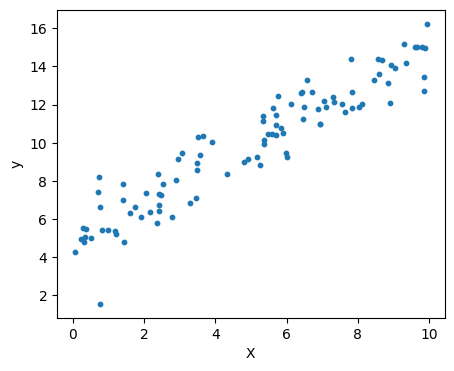

In [6]:
a, b= 1, 5
X = np.random.random(size=100) * 10
y = X * a + b + np.random.normal(size=100) # 표준 정규 분포를 따르는 노이즈를 더하여 기울기가 a 이고 절편이 b 인 관계를 지니는 데이터 포인트를 만듭니다.
plt.figure(figsize=(5, 4))
plt.scatter(X, y, s=10)
plt.gca().set_xlabel('X')
plt.gca().set_ylabel('y')
plt.show()

**모델**: 직선  

y = aX + b을 사용하여 X, y 의 관계를 나타냅니다.

이 케이스는 a, b를 알고 있으니(a = 1 , b = 5) 이를 이용하여 나타내 봅니다. 

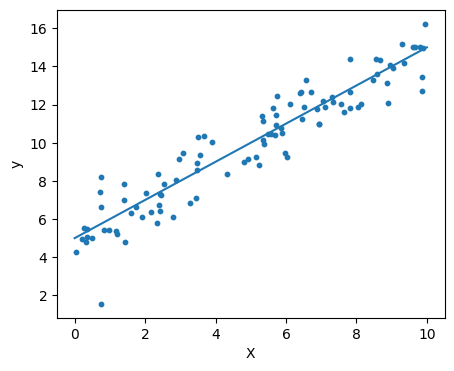

In [7]:
a, b = 1, 5
plt.figure(figsize=(5, 4))
plt.scatter(X, y, s=10)
plt.plot((0, 10), (a * 0 + b, a * 10 + b))
plt.gca().set_xlabel('X')
plt.gca().set_ylabel('y')
plt.show()

## 손실(Loss)

**근사화**에 의해 발생한 실제 데이터와의 오차를 정량화 : 클수록 실제데이터와 차이가 많이 남을 뜻합니다.


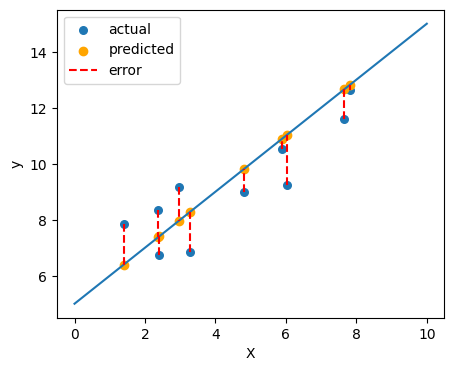

In [8]:
# 도식화를 10개만 뽑아 냈습니다.

idx_10 = np.random.choice(np.arange(100), 10)
X, y = X[idx_10], y[idx_10]
plt.figure(figsize=(5, 4))
plt.plot((0, 10), (a * 0 + b, a * 10 + b))
plt.scatter(X, y, s=30, label='actual')
plt.scatter(X, X * a + b, color='orange', label='predicted')
plt.vlines(X, y, X * a + b, linestyles='dashed', color='red', label='error')
plt.gca().set_xlabel('X')
plt.gca().set_ylabel('y')
plt.legend()
plt.show()

In [9]:
pd.DataFrame(
    {'X': X, 'y': y}
).assign(
    y_hat = lambda x: X * a + b
).assign(
    error = lambda x: x['y'] - x['y_hat'], # 오차
).assign(
    absolute_error = lambda x: x['error'].abs(), # 절대 오차
    squared_error = lambda x: x['error'] ** 2 # 제곱 오차
)

,X,y,y_hat,error,absolute_error,squared_error
0,4.813957,8.997131,9.813957,-0.816825,0.816825,0.667204
1,7.652294,11.614142,12.652294,-1.038153,1.038153,1.077761
2,2.952208,9.157656,7.952208,1.205448,1.205448,1.453105
3,3.287346,6.848648,8.287346,-1.438697,1.438697,2.069850
4,1.398986,7.836600,6.398986,1.437614,1.437614,2.066735
5,2.376702,8.349189,7.376702,0.972487,0.972487,0.945730
6,5.890922,10.524958,10.890922,-0.365964,0.365964,0.133930
7,2.406788,6.756161,7.406788,-0.650628,0.650628,0.423316
8,6.018378,9.253215,11.018378,-1.765163,1.765163,3.115800
9,7.823182,12.648211,12.823182,-0.174971,0.174971,0.030615


**error**, **absolute_error**, **squared_error** 에서 Loss로 사용할 수 있는 것은?

> absolute_error

> squared_error


## 학습 (Train)

데이터의 **손실**을 최소화 시키도록 모델을 찾는 과정입니다.

# 머신러닝(Machine Learning)의 종류

## 지도 학습(Supervised Learning)

- 머신러닝 모델을 정답이 주어진 데이터로 학습(Training)을 시키는 것

### 회귀 (Regression)

- 정답이 수치형

- 손실: Mean Squared Error

  > $MSE = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$

Ex) 사용자의 아이템에 대한 평점을 예측

### 분류 (Classfication)

- 정답이 범주

- 손실: Cross Entropy 

  > $H(y, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n} y_i \log(\hat{y}_i)$

  이진분류일 경우 다음과 같이 축약할 수 있습니다.

  > $H(y, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n} \left(y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right)$

Ex) 사용자가 아이템을 좋아요/싫어요 피드백을 예측

## 비지도 학습(Unsupervised Learning)

- 머신러닝 모델을 정답이 주어지지 않은 데이터로 학습(Training)을 시키는 것

## 성능 지표(Performance Metric)

- 머신러닝 모델을 평가하는 기준

- Metric과 Loss는 같을 수도 있고, 다를 수도 있습니다. 
  
  Metric과 Loss가 다른 과제는 Loss를 낮추는 것이 Metric을 낮추는 것을 보장하지 않기 때문에 이 갭을 메꾸기 위한 방법이 필요합니다.

### 회귀

  - Mean Squared Error(MSE)
  
    > $MSE = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$
    
  - Mean Absolute Error(MAE)
  
    > $MAE = \frac{1}{n}\sum_{i=1}^{n}|\left(y_i - \hat{y}_i)\right|$
    
  - R2 Score
  
    > $R^2 = 1 - \frac{MSE}{VAR(y)}$
  
### 분류

  - 정확도(Accuracy)
    
    > $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
  
  - 정밀도(Precision)
  
    > $Precision = \frac{TP}{TP + FP}$
  
  - 재현율(Recall)
    
    > $Recall = \frac{TP}{TP + FN}$
    
## 모델 검증 

투입할 모델을 선택하기 위한 제작한 머신러닝 모델이 **실제 상황**에서 **성능**을 **측정**하는 과정입니다.

  - 홀드아웃(Hold-out) 검증: 학습(Train)/검증(Validation) 단순 분리

  - 교차 검증 (Cross-Validation)

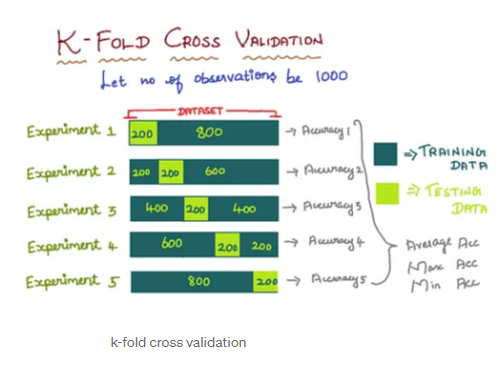

# 기계학습의 궁극 목표

- 실제 투입이 되었을 때 성능이 좋은 머신러닝 모델을 만드는 것 → 일반화(Generalization)

  > 학습 데이터를 통해 일반화(Generalized)된 머신러닝 모델을 만드는 것
  
  > 과적합(Over-fit): 학습데이터에 모델이 지나치게 맞추어져 학습데이터에 치우침에 의해 일반성을 잃어 버린 상태입니다.
  
  > 과소적합(Under-fit): 학습데이터에 모델이 덜 맞추어져 현상을 제대로 모델이 담지 못하여 낮은 일반성을 지닌 상태입니다.
    
  ⇒ 모델이 투입이 되는 상황에 맞춰어 평가(Test) 체계를 만들고, 이에 맞추어 모델을 검증
  
  ⇒ 속성 공학 - 파생 변수 생성, 차원 축소, 스캐일링, ... 
  
  ⇒ 최적합 모델을 도출 - 모델 튜닝, 앙상블, ...

# 용어 정의

> 대상 변수(Target Variable) - 지도학습에서 정답에 해당하는 변수

> 입력 변수(Input Variable) - 기계학습 모델에 입력 변수

> 모수 (Parameter) - 모집단이 지니는 특징을 나타내는 수. 모평균 / 모분산 ...

> 가중치 (Weight) - 인공신경망에서의 모수(Parameter)

> 손실 (Loss) - 모델링을 통해서 발생한 실제 현상에 대한 정보 손실


# 머신러닝 모델 (Machine Learning Model)


## 모수적 모델(Parametric Model)

> 모집단의 지식(패턴)을 고정된 함수 구조로 나타내는 모델

- Ex) 선형 모델, 신경망 모델

- 학습: 학습 데이터를 통해 함수의 모수를 추정하는 것

  ⇒  학습 데이터에 대한 모델의 손실을 최소화하는 모수를 찾는 것

### 모수적 모델의 규제

- 학습셋에 적합시키는 정도를 제한하기 위한 방법

모수의 크기(Magnitude)의 합을 규제 계수와 곱하고 손실 함수에 더합니다.

모수의 크기(Magnitude)가 커질 수록 손실이 커지게 되므로,

모수의 크기(Magnitude)가 커지는 것이 억제됩니다.

규제 계수의 크기에 따라 규제의 강도를 조절할 수 있습니다.

> L1-norm: 모수의 절대값의 합을 손실 함수에 반영

> L2-norm: 모수의 제곱의 합을 손실 함수에 반영

### 선형 회귀 모델(Linear Regression)

대상 변수를 선형 함수로 나타낸 모델

$\hat{y_i} = \hat{\beta}_1x_{i1} + \hat{\beta}_2x_{i2} + ... + \hat{\beta}_nx_{in} + \hat{\beta}_0$

<=> $\hat{y} = X \hat{\beta} + \hat{\beta}_0$

**학습 알고리즘**

  1.정규방정식(OLS, Ordinary Least Square)
  
  정규방정식의 해 아래와 같이 닫힌 형태로 구할 수 있습니다.
  
  $\hat{\beta} = (X^T X)^{-1} X^T y$
  
  2.경사하강법(Gradient Descent)
  
  - 손실(Loss)에 대한 모수의 기울기(Gradient)를 측정하여 손실(Loss)을 낮추는 방향으로 모수를 찾아가는 방법
  
  $Loss = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$
  
  $\frac{dLoss}{d\hat{\beta}} = -\frac{2}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)x_i}$

#### **예제: 선형회귀 모델의 학습**

In [10]:
from sklearn.datasets import make_regression

# 예제로 사용할 데이터셋을 만듭니다.
X, y = make_regression(
    n_samples=100, 
    n_features=1,  # 입력 변수는 한 개로 합니다,
    n_informative=1, 
    noise=4.0,
    bias=1.0, 
    random_state=123
)

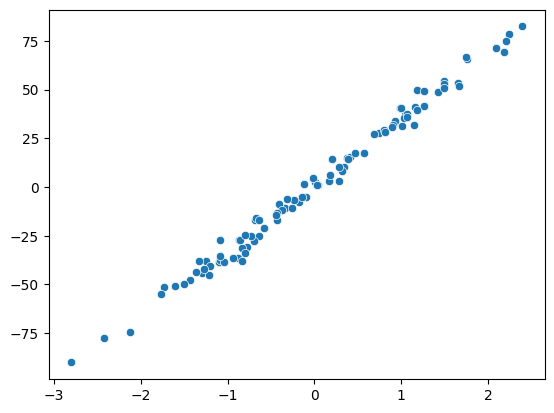

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 입력 변수와 대상 변수를 산포도 그래프로 출력합니다.
sns.scatterplot(x = X[:, 0], y = y)
plt.show()

**Task** 

위 데이터는 입력 데이터는 한 개, 출력 데이터는 한 개인 선형 관계를 지닌 데이터 입니다.

이 데이터가 절편이 있는 선형 회귀 모델을 따른다는 것을 아래와 같이 가정합니다.

$ y = \beta_1 x + \beta_0$

모수적 모델의 학습 함수의 계수들을 구하는 것입니다.

손실 함수가 Mean Squared Error 일 때, 위 데이터를 학습해봅니다.

**1. 정규방정식 (Ordinary Least Square, OLS)**

2차 방정식의 근의 공식이 있듯이, 선형 회귀 모델의 계수를 구하는 것은 공식화 되었습니다. 

이 공식을 바로 정규방정식이라고 합니다.

$\hat{\beta} = (X^T X)^{-1} X^T y$

In [12]:
# Linear Regression의 상수항(beta_hat_0)을 행렬연산에 포함시켜 구하기 위해 모두 1인 입력변수를 추가합니다.
X_1 = np.hstack([X, np.ones((X.shape[0], 1))])
# 처음 5행만 출력합니다.
X_1[:5]

array([[-0.09470897,  1.        ],
       [-1.25388067,  1.        ],
       [ 0.00284592,  1.        ],
       [ 1.03972709,  1.        ],
       [-0.43435128,  1.        ]])

In [13]:
# OLS를 통한 Linear Regression 모델 학습
X_gram = np.dot(X_1.T, X_1)# X_1^T, X_1 행렬곱을 합니다.
X_gram_inv = np.linalg.inv(X_gram)# X_gram의 역행렬을 구합니다.
beta_hat = np.dot(X_gram_inv, np.dot(X_1.T, y)) # beta_hat을 구합니다.
beta_hat

array([33.9064697 ,  0.96504735])

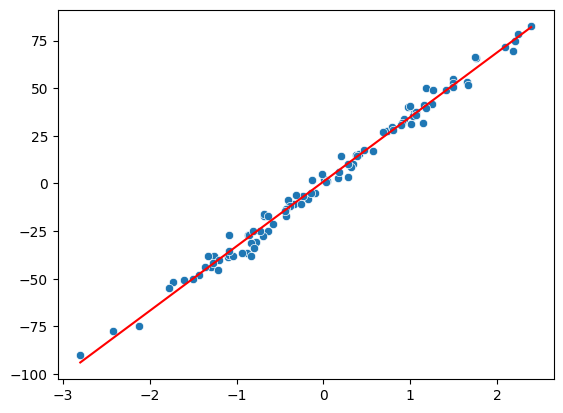

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def linear_reg(X_1, beta_hat):
    """
    학습을 통해 도출한 beta_hat으로 y값 예측합니다.
    """
    return np.dot(X_1, beta_hat)

def plot_linear_model(x_min, x_max, beta_hat, **kwarg):
    """
    beta_hat의 회귀선을 출력합니다.
    """
    x_range = np.array([
        [x_min, 1], 
        [x_max, 1]
    ])
    sns.lineplot(x=x_range[:, 0], y=linear_reg(x_range, beta_hat), **kwarg)
    
sns.scatterplot(x = X[:, 0], y = y)
# 선형 회귀선을 출력합니다.
plot_linear_model(X[:, 0].min(), X[:, 0].max(), beta_hat, color='red')
plt.show()

**2. 경사하강법(Gradient Descent)**

근의 공식은 2차 방정식에

정규 방정식은 선형회귀 모델에만 사용할 수 있는 학습 방법입니다.

선형 회귀 모델을 뿐만 아니라 모수와 손실간의 경사도를 계산할 수 있는 모수적 모델에 적용 가능한,

간단히 말해 보다 다양한 모수적 모델에 적용이 가능한 경사하강법을 소개합니다.


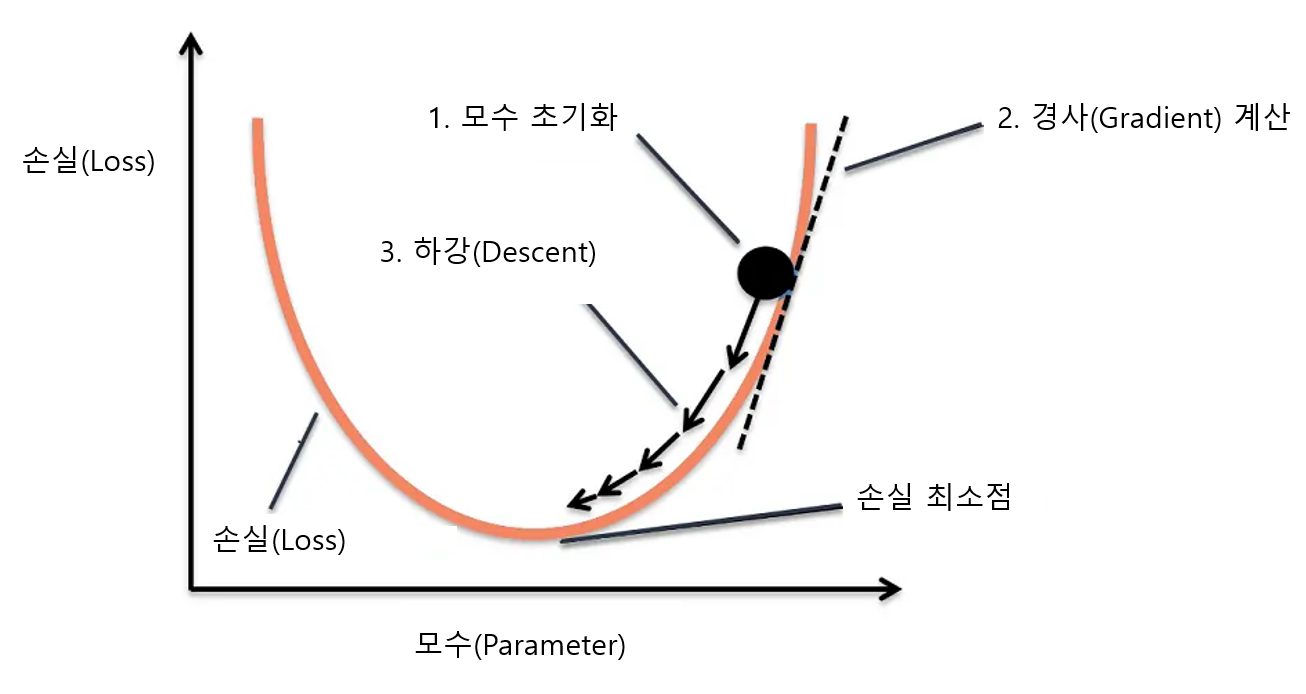


**Step.1** 

모수 초기화

In [15]:
# 초기화: (-1, 1) 사이의 임의의 2개의 실수를 만듭니다.
beta_hat = np.random.uniform(-1, 1, 2)
beta_hat

array([-0.51062937, -0.66122977])

**Step 2**

$\frac{dLoss}{d\hat{\beta}} = -\frac{2}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)x_i}$

손실에 대한 회귀 계수의 미분을 이용한 경사(기울기)를 계산하여 손실이 줄어드는 방향으로

계수를 업데이트하여 선형 회귀 모델의 계수 (선형 회귀 계수)를 구해봅니다.

In [16]:
# 먼저 y_hat: 예측값을 구해봅니다.
y_hat = np.dot(X_1, beta_hat)
y_hat

array([-6.12868585e-01, -2.09614736e-02, -6.62682974e-01, -1.19214495e+00,
       -4.39437248e-01, -4.93420103e-02,  5.77903921e-01, -3.34987643e-01,
       -1.38494428e+00, -3.65779485e-01, -3.09473032e-01, -2.66662004e-01,
       -1.13481932e+00, -1.26164261e+00, -7.45198287e-01, -1.16100111e+00,
       -3.14570559e-01, -6.84458337e-01, -2.36817622e-01, -2.12112679e-01,
       -1.17392917e+00, -1.00965668e-01, -1.55732619e+00, -4.61624851e-01,
       -1.42494958e+00, -5.72566287e-01,  4.22887623e-01, -1.83365509e-01,
       -8.34123278e-01, -2.18646662e-01, -2.21192408e-01, -3.03851896e-01,
       -1.77786696e+00, -7.63112617e-01, -1.12442432e+00, -6.55188768e-01,
       -1.80409148e+00, -1.06736110e-01, -2.87213165e-01, -1.50450176e+00,
       -1.30793999e-01,  2.20969015e-01, -4.31795844e-04, -1.72697114e+00,
       -8.54962860e-01, -4.90163432e-01, -1.42277711e+00, -8.72074841e-01,
       -8.21706275e-01, -8.06058206e-01, -9.54231890e-01, -1.88284173e+00,
       -2.53715496e-01, -

In [17]:
np.sum(np.expand_dims(y - y_hat, -1) * X_1, axis=0)

array([4387.98195557,  255.92927875])

$\sum_{i=1}^{n}{a_i b_i} = a \cdot b$ 임을 이용하여 연산을 줄여 봅니다.

In [18]:
np.dot(y - y_hat, X_1)

array([4387.98195557,  255.92927875])

$\frac{dLoss}{d\hat{\beta}} = -\frac{2}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)x_i}$

In [19]:
beta_hat_grad = -2 * np.dot(y - y_hat, X_1) / X_1.shape[0]
beta_hat_grad

array([-87.75963911,  -5.11858557])

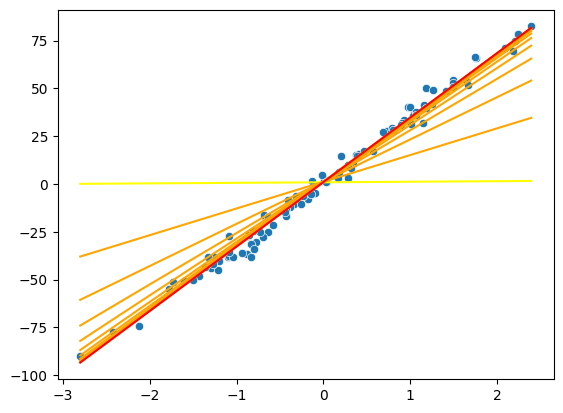

In [20]:
beta_hat = np.random.uniform(-1, 1, 2) #  -1, 1 사이의 임의 수 2개를 생성합니다.
sns.scatterplot(x = X[:, 0], y = y)
# 선형 회귀선을 출력합니다.
plot_linear_model(X[:, 0].min(), X[:, 0].max(), beta_hat, color='yellow')

learning_rate = 0.02 # 학습율(속도)
# Epoch마다 손실(loss)을 기록하기 위한 리스트
losses = []
for epoch in range(100):
    y_hat = np.dot(X_1, beta_hat) # 현재 회귀 계수의 X_1에 대한 예측 값을 구합니다.
    beta_hat_grad = - 2 * np.dot(y - y_hat, X_1) / X_1.shape[0] # 회귀 계수들의 경사도를 구합니다.

    # Step 3 하강
    beta_hat -= beta_hat_grad * learning_rate # 회귀 계수를 업데이트 합니다.
    
    # 10 epoch 마다 회귀선을 출력합니다.
    if (epoch + 1) % 10 == 0:
        plot_linear_model(X[:, 0].min(), X[:, 0].max(), beta_hat, color='orange')

    loss = np.mean((y_hat - y) ** 2) # Loss Function: Mean Squared Error를 계산합니다.
    
    losses.append(loss)
# 최종 학습된 선형 회귀선을 출력합니다.
plot_linear_model(X[:, 0].min(), X[:, 0].max(), beta_hat, color='red')
plt.show()

In [21]:
beta_hat

array([33.72465047,  1.00215666])

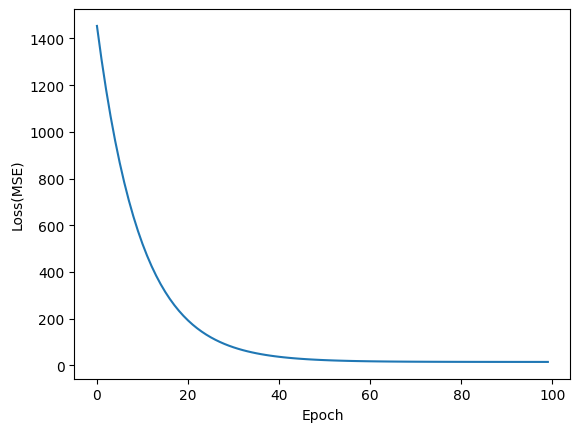

In [22]:
# 경사하강법의 반복횟수(Epoch)에 따른 손실을 출력합니다.
sns.lineplot(losses)
plt.gca().set_xlabel('Epoch')
plt.gca().set_ylabel('Loss(MSE)')
plt.show()

In [23]:
from sklearn.linear_model import SGDRegressor
reg_sgd = SGDRegressor().fit(X, y)
reg_sgd.coef_, reg_sgd.intercept_

(array([33.87681139]), array([0.97454848]))

- Ridge 모델: Linear Regression에 L2 규제를 적용한 모델

- Lasso 모델: Linear Regression에 L1 규제를 적용한 모델 

- Elastic Net: Linear Regression에 L1/L2 규제를 적용한 모델

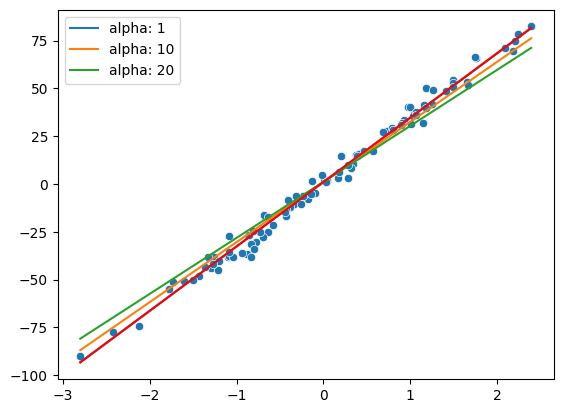

In [24]:
from sklearn.linear_model import Ridge

sns.scatterplot(x = X[:, 0], y = y)
# 규제의 강도(1, 10, 20)에 따른 선형 회귀선을 출력합니다.
for alpha in [1, 10, 20]:
    reg_rd = Ridge(alpha=alpha)
    reg_rd.fit(X, y)
    plot_linear_model(X[:, 0].min(), X[:, 0].max(), np.array([reg_rd.coef_[0], reg_rd.intercept_]), label='alpha: {}'.format(alpha))
    y_hat = reg_rd.predict(X)
    losses.append(np.mean(np.square(y - y_hat)))
plot_linear_model(X[:, 0].min(), X[:, 0].max(), beta_hat, color='red')
plt.show()

**Tensorflow**

**Tensor란?**

n차원 배열 (n이 0이면 단일수, n이 1이면 Vector, n이 2이면 Matrix, n이 3이면 Cube, ...

머신러닝 관점에서 Tensorflow를 한 마디로, 모수적 모델을 구현하기 위한 라이브러리입니다.

Matrix Factorization, 딥러닝은 모수적 모델입니다. 

이 후 파트에서는 Tensorflow를 통한 모델링 학습이 주를 이룹니다.

이를 위해 Tensorflow에 익숙해져 보기 위해 예를 들어 봅니다.

모수(Parameter)라는 단어는 통계 분야에서 주로 사용한 단어입니다. 

Machine Learning에서는 모수(Parameter)보다는 **가중치(Weight)** 를 주로 사용합니다.

Tensorflow에서는 가중치(Weight)라는 단어를 사용합니다. 여기서 부터는 모수(Parameter)를 가중치(Weight)로

사용하도록 하겠습니다.

In [25]:
# TF_CPP_MIN_LOG_LEVEL: Tensorflow에서 출력할 로그의 수준을 지정합니다. 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

# 불필요한 경고 메세지가 너무 많이 나와서 내용 파악에 어려움이 있어
# Tensorflow에서 출력하는 경고 메세지를 보이지 않게 조정합니다.
# 개발 단계에서는 비활성화 시키지 않는 것을 권장드립니다. 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

2025-03-18 09:45:55.282201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742258755.634908    1054 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742258755.731399    1054 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742258756.455948    1054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742258756.456076    1054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742258756.456092    1054 computation_placer.cc:177] computation placer alr

In [26]:
# 장치의 GPU 현황을 조사합니다.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리를 최대한 활용할 수 있도록 설정합니다.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1742258762.902499    1054 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


**단일 변수 회귀 모델을 밀도층으로 모델링**

딥러닝 툴인 Tensorflow로 단일 회귀 모델을 나타내는 가장 간단한 방법은

딥러닝의 밀도 레이어를 사용하면 됩니다.

입력의 수가 1개이고 출력의 수가 한 개인 단일 밀도층으로 구성된 모델이 바로

밀도층으로 구현한 선형 회귀 모델입니다.

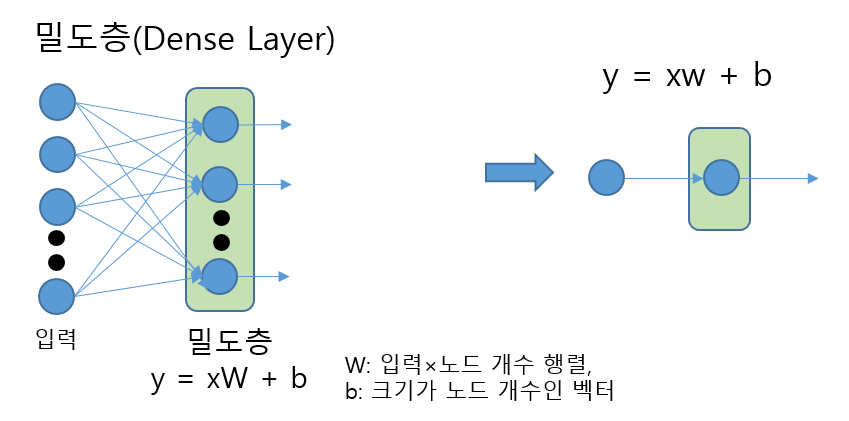

In [27]:
# Tensorflow로 선형회귀 모델(Linear Regression Model)을 정의합니다.
class LRModel(tf.keras.Model):
    def  __init__(self):
        super().__init__()
        # 출력이 한 개인 밀도 레이어 단층의 신경망
        # Dense Layer에는 입력변수 × 출력변수 형태의 가중치 행렬(Weight Matrix)와 절편(Intercept)이 있습니다.
        # 출력 변수가 1개인 Dense Layer를 생성합니다.
        self.beta_hat = tf.keras.layers.Dense(1)

    def call(self, X):
        y_hat = self.beta_hat(X) # X를 beta_hat Layer에 통과 시켜 예측값을 구합니다.
        return y_hat

# Tensorflow 세션 초기화
tf.keras.backend.clear_session()
# 모델 생성합니다. 
lr_model = LRModel()

In [28]:
# 모델의 구동을 확인해봅니다.
lr_model(tf.constant([[1.0], [2.0], [3.0]]))

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-1.095911],
       [-2.191822],
       [-3.287733]], dtype=float32)>

In [29]:
# Dense Layer의 Weight는  입력 텐서[-1] x 출력 텐서[-1]의 weight와 출력 텐서[-1]의 절편으로 구성 돼있습니다.
lr_model.beta_hat.get_weights()[0] * tf.constant([[1.0], [2.0], [3.0]]) + lr_model.beta_hat.get_weights()[1] 

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-1.095911],
       [-2.191822],
       [-3.287733]], dtype=float32)>

In [30]:
# Dense Layer의 가중치 곧 선형 회귀 모델 관점에서 모수를 확안해 봅니다.
lr_model.beta_hat.get_weights()

[array([[-1.095911]], dtype=float32), array([0.], dtype=float32)]

In [31]:
lr_model.summary()

Model: "lr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (3, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

**Keras**

Deep Learning Framework - Deep Learning을 위한 요소들을 틀로써 정의

**학습 방법 1: Train Loop를 통한 학습**

In [32]:
tf.keras.optimizers.Adagrad
''

''

In [33]:
# 손실함수를 생성합니다. Mean Squared Error(MSE)
mse = tf.keras.losses.MeanSquaredError()
# 옵티마이저(손실함수를 낮추는 가중치(Weight)를 찾아주는 모듈)을 생성합니다.: Adaptive Gradient Descent 최적화기
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 2.0)# 학습율을 2.0로 설정합니다.
@tf.function
def train_step(X, y):
    # 모델에서 예측값을 구하고, 예측값과 실제값의 손실을 구하는 과정을 tape 객체에 담습니다. 이를 통해 경사도가 계산됩니다.
    with tf.GradientTape() as tape:
        y_hat = lr_model(X)
        loss = mse(y, y_hat)
    # 모델에서 학습 가능한 가중치를 가져옵니다.
    variables = lr_model.trainable_variables
    # 가중치에 대한 경사도를 구합니다.
    gradients = tape.gradient(loss, variables)
    # 구한 기울기를 가지고 가중치를 업데이트합니다
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

**Auto Diff.** :머신 러닝 관점에서 Tensorflow의 핵심 기능 모델의 계수(가중치, Weight)들의 손실에 대한 경사도를 구해줍니다.

**Tensorflow의 모델 구동 방식**

- Eager Execution - 정의된 연산 단계를 즉각적으로 실행

- Graph Execution - Graph로 표현된 연산 단계를 최적화하여 실행

@tf.function - 지정한 함수안에 연산들을 Graph Execution 방법으로 구동 시키도록합니다.

**Batch** - 데이터를 지정한 숫자 만큼을 나누어 전달토록 합니다.

> 전체 데이터에서 Batch 단위로 나누어 Gradient를 구합니다.

안정적인 학습을 할 수 있는 충분한 수의 Batch를 연산 장치가 수용할 수 있다면,

저장 장치가 허용하는 만큼의 데이터를 학습시킬 수 있습니다.

- 모델의 복잡도가 클수록 많은 큰 사이즈의 Batch가 필요

- 데이터의 복접도가 클수록 많은 큰 사이즈의 Batch가 필요

In [34]:
# Tensorflow 용 Dataset으로 만들어 줍니다. # batch - 64개
ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(64)
losses = []
for epoch in range(100):
    losses_epoch = []
    for X_, y_ in ds:
        losses_epoch.append(
            train_step(X_, y_).numpy()# train_step을 수행하고 손실함수를 기록합니다.
        )
    losses.append(np.mean(losses_epoch))

In [35]:
lr_model.beta_hat.get_weights()

[array([[31.518497]], dtype=float32), array([1.1245542], dtype=float32)]

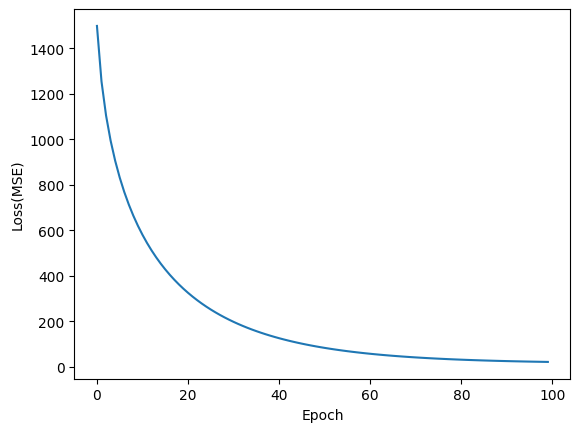

In [36]:
sns.lineplot(losses)
plt.gca().set_xlabel('Epoch')
plt.gca().set_ylabel('Loss(MSE)')
plt.show()

In [37]:
# Dense Layer의 가중치 곧 선형 회귀 모델 관점에서 모수를 확안해 봅니다.
lr_model.beta_hat.get_weights()

[array([[31.518497]], dtype=float32), array([1.1245542], dtype=float32)]

**학습 방법 2: fit 메소드를 통한 학습**

compile ~ fit 루틴

compile: 모델 학습에 필요한 설정을 합니다.

fit: 데이터셋에 대한 학습 작업을 수행시킵니다.

In [59]:
# lr_model을 학습하기 위한 설정을 합니다.
lr_model = LRModel()

lr_model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate = 2.0), # 경사하강 알고리즘을 셋팅합니다: Adaptive Gradient Descent, learing_rate = 2.0
    loss= tf.keras.losses.MeanSquaredError(), # 손실함수를 설정합니다. MeanSquredError, MSE
    metrics= [tf.keras.metrics.MeanSquaredError(name = 'mse')]# mse: Mean Squared Error 모델 성능 측정지표를 성정합니다.
)

# epochs: 최적화 루팅 반복 회수, 100회
# verbose: 0 - 중간 결과 출력을 생략합니다.
# 확습을 시킵니다.
hist = lr_model.fit(ds, epochs = 100, verbose = 0)

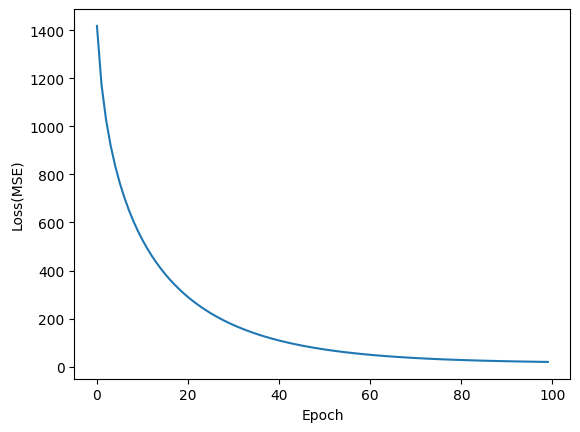

In [46]:
sns.lineplot(hist.history['mse'])
plt.gca().set_xlabel('Epoch')
plt.gca().set_ylabel('Loss(MSE)')
plt.show()

**Gradient Descent의 의미**

1. Loss에 대한 모수의 기울기만 구할 있다면,  모든 모수 모델에 대하여 적용이 가능합니다.

2. 데이터 스트림을 통한 학습이 가능합니다. 

  > 모델 학습 시 전체 데이터를 메모리에 올리지않고, 학습에 필요한 Batch 단위로 나누어 진행합니다.
  
  > 대규모의 학습 데이터를 입력으로 사용 가능합니다.


#### 실습: MovieLens100K 데이터셋에서 추천에 활용할 수 있는 모델을 만들어 봅니다.

Task: 추천시 Ranking에 활용할 수 있도록 사용자별 영화 평점 예측기를 만들어 봅시다. 

지표: R2

학습데이터:평가데이터 = 8:2

검증법: 5-fold cross validation


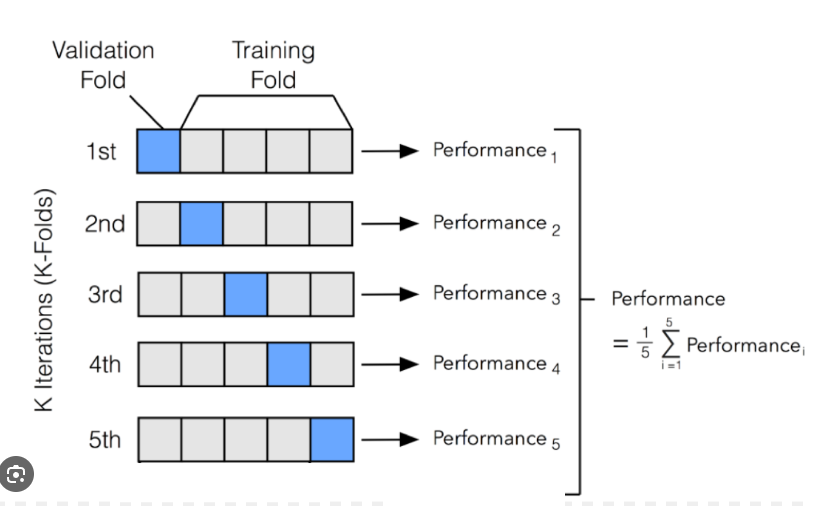

### **선형 회귀**모델을 이용한 초간단 평점 예측 모델

MovieLens 100K에서  80%는 학습, 20%는 평가데이터로 구성합니다. 

입력변수: 사용자의 rating 평균, 영화의 rating 평균

로 하여 rating(평점)을 맞추는 선형회귀 모델을 학습하고 평가해봅니다.

In [60]:
from sklearn.model_selection import train_test_split
# 학습:평가 = 8:2로 하여 학습/평가를 셋을 합니다.
df_train, df_test = train_test_split(df_ratings, train_size=0.8, random_state=123)

In [61]:
df_train.shape, df_test.shape

((80000, 4), (20000, 4))

**TargetEncoder**

범주형 변수를 수준별 대상값에 대한 평균으로 인코딩해주는 전처리기 입니다.

In [67]:
from sklearn.preprocessing import TargetEncoder
tgt = TargetEncoder(target_type = 'continuous')
tgt.fit(df_train[['user id', 'item id']], df_train['rating'])
tgt.transform(df_train[['user id', 'item id']])[:5]

array([[3.39303134, 3.43011389],
       [3.72487552, 4.23383989],
       [3.38681329, 3.62972923],
       [3.98684472, 3.88208099],
       [4.17601163, 4.01981339]])

In [68]:
pd.concat([
    df_train.groupby('user id')['rating'].transform('mean'),
    df_train.groupby('item id')['rating'].transform('mean')
], axis=1).head()

,rating,rating
22302,3.392749,3.429577
49609,3.727273,4.237037
89251,3.386454,3.630435
96385,3.988571,3.883249
17569,4.177966,4.022059


**Pipeline**

단계별 데이터 처리 과정들을 결합하여 하나의 모델로 만듭니다.

Ex) TargetEncoder + LinearRegression

In [85]:
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression

X_lr = ['user id', 'item id']
reg_lr = make_pipeline( # 전처리기와 모델을 결합하여 하나의 모델 객체로 구성합니다.
    TargetEncoder(target_type = 'continuous', cv = 2), # 범주형 변수의 수준별 Target(Rating)의 평균으로 인코딩
    LinearRegression()# 선형 회귀 모델 
)
# 학습
reg_lr.fit(df_train[X_lr], df_train['rating'])
# 예측
reg_lr.predict(df_test[X_lr])

array([3.96386502, 4.00021825, 4.1749235 , ..., 4.03966242, 3.77120116,
       2.63887092])

**5-fold cross validation**

예제를 통해 이해해 봅니다.

In [81]:
# 처음 5개의 셋만 가져옵니다.
df_train_5 = df_train.iloc[:5]
df_train_5

,user id,item id,rating,date
22302,429,24,3,1997-12-17 19:18:29
49609,480,511,4,1998-03-29 21:56:39
89251,916,746,3,1997-11-29 22:57:42
96385,892,196,4,1998-02-04 16:27:02
17569,90,83,5,1998-03-31 22:34:47


In [86]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
cv = KFold(5, random_state=1, shuffle=True)
cnt = 1
scores = list()
for train_idx, test_idx in cv.split(df_train_5):
    df_cv_train = df_train_5.iloc[train_idx] # 검증 학습셋
    print("검정 학습셋: {}".format(cnt))
    display(df_cv_train)
    reg_lr.fit(df_cv_train[X_lr], df_cv_train['rating'])

    print("검정  테스트셋: {}".format(cnt))
    df_cv_test = df_train_5.iloc[test_idx] # 검증 테스트셋
    prd = reg_lr.predict(df_cv_test[X_lr]) # 예측합니다.
    display(df_cv_test)
    score = mean_squared_error(df_cv_test['rating'], prd) # 지표 측정합니다.
    scores.append(score)
    print('Validation #{}, MSE: {:.5}'.format(cnt, score)) # 검정 라운드별 성능을 출혁합니다.
    cnt += 1
print(scores, np.mean(scores))

검정 학습셋: 1


,user id,item id,rating,date
22302,429,24,3,1997-12-17 19:18:29
49609,480,511,4,1998-03-29 21:56:39
96385,892,196,4,1998-02-04 16:27:02
17569,90,83,5,1998-03-31 22:34:47


검정  테스트셋: 1


,user id,item id,rating,date
89251,916,746,3,1997-11-29 22:57:42


Validation #1, MSE: 1.0
검정 학습셋: 2


,user id,item id,rating,date
22302,429,24,3,1997-12-17 19:18:29
89251,916,746,3,1997-11-29 22:57:42
96385,892,196,4,1998-02-04 16:27:02
17569,90,83,5,1998-03-31 22:34:47


검정  테스트셋: 2


,user id,item id,rating,date
49609,480,511,4,1998-03-29 21:56:39


Validation #2, MSE: 0.0625
검정 학습셋: 3


,user id,item id,rating,date
22302,429,24,3,1997-12-17 19:18:29
49609,480,511,4,1998-03-29 21:56:39
89251,916,746,3,1997-11-29 22:57:42
96385,892,196,4,1998-02-04 16:27:02


검정  테스트셋: 3


,user id,item id,rating,date
17569,90,83,5,1998-03-31 22:34:47


Validation #3, MSE: 2.25
검정 학습셋: 4


,user id,item id,rating,date
49609,480,511,4,1998-03-29 21:56:39
89251,916,746,3,1997-11-29 22:57:42
96385,892,196,4,1998-02-04 16:27:02
17569,90,83,5,1998-03-31 22:34:47


검정  테스트셋: 4


,user id,item id,rating,date
22302,429,24,3,1997-12-17 19:18:29


Validation #4, MSE: 1.0
검정 학습셋: 5


,user id,item id,rating,date
22302,429,24,3,1997-12-17 19:18:29
49609,480,511,4,1998-03-29 21:56:39
89251,916,746,3,1997-11-29 22:57:42
17569,90,83,5,1998-03-31 22:34:47


검정  테스트셋: 5


,user id,item id,rating,date
96385,892,196,4,1998-02-04 16:27:02


Validation #5, MSE: 0.0625
[0.9999999999999991, 0.0625, 2.2500000000000013, 0.9999999999999991, 0.06250000000000022] 0.875


**sklearn.model_selection.cross_validate**

상기의 과정을 함수로 구현한 것입니다.

In [90]:
from sklearn.model_selection import KFold, cross_validate
reg_lr = make_pipeline( # 전처리기와 모델을 결합하여 하나의 모델 객체로 구성합니다.
    TargetEncoder(target_type = 'continuous', cv = 2), # 범주형 변수의 수준별 Target(Rating)의 평균으로 인코딩
    LinearRegression()# 선형 회귀 모델 
)
result = cross_validate(
    reg_lr, df_train_5[X_lr], df_train_5['rating'], scoring = 'neg_mean_squared_error',
    cv = KFold(5, random_state = 1, shuffle = True), 
)
result, np.mean(-result['test_score'])

({'fit_time': array([0.00493693, 0.00310683, 0.0034945 , 0.00227737, 0.0028851 ]),
  'score_time': array([0.00146008, 0.00158429, 0.00117922, 0.00128913, 0.00162148]),
  'test_score': array([-1.    , -0.0625, -2.25  , -1.    , -0.0625])},
 np.float64(0.8749999999999998))

In [92]:
# 모델 검증 프로세스부터 구현합니다.
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score

# 5-fold cross validate splitter를 설정합니다. random_state=123, shuffle=True
cv = KFold(n_splits=5, random_state=123, shuffle=True)
def eval_model(model, df, X):
    # cross_validate를 활용하여 R2 Score를 지표로하고 Splitter는 5-fold cross validate, train_score까지 반환토록하여 model 성능을 측정합니다.
    # scoring = 'r2', 
    return cross_validate(
        model, df[X], df['rating'], scoring = 'r2', cv = cv, return_train_score = True
    )

In [94]:
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

X_lr = ['user id', 'item id']
# user id, item id에 대한 Target Encoder 를 설정합니다.. target_type = 'continuous': target이 연속형 변수
# Target Encoder와 Linear Regression을 결합합니다.
reg_lr = make_pipeline(
    TargetEncoder(target_type = 'continuous'),
    LinearRegression()
)
result = eval_model(reg_lr, df_train, X_lr)
result, np.mean(result['test_score'])

({'fit_time': array([0.02738476, 0.02387881, 0.02281785, 0.02336717, 0.02229333]),
  'score_time': array([0.00363898, 0.00386333, 0.00373459, 0.0035975 , 0.00351095]),
  'test_score': array([0.271582  , 0.27551428, 0.27204973, 0.26486362, 0.28175462]),
  'train_score': array([0.32316787, 0.32227432, 0.32259947, 0.32351627, 0.31989493])},
 np.float64(0.27315285055961613))

In [95]:
from sklearn.metrics import r2_score
# reg_lr을 rating에 대해 학습시킵니다.
reg_lr.fit(df_train[X_lr], df_train['rating'])
# df_test의 rating을 예측하고, 정답과의 r2_score를 구합니다.
r2_score(
    df_test['rating'], reg_lr.predict(df_test[X_lr])
)

0.2751618628145771

### 실습: 사용자의 직업, 성별과 영화 장르 정보를 입력 변수에 추가하여 rating  예측 모델의 기능을 추가해봅니다.

직업과 성별은 OneHotEncoder를 사용합니다. 

그리고 장르는 장르의 해당 여부를 그대로 전달합니다.

In [99]:
# gender, occupation을 활용하기 위에 df_user와 결합합니다.
# genre를 활용하기 위해 df_movie와 결합합니다.
df_train_2 = df_train.join(df_user, on='user id').join(df_movie, on='item id')
df_test_2 = df_test.join(df_user, on='user id').join(df_movie, on='item id')
df_train_2.head()

,user id,item id,rating,date,age,gender,occupation,zip code,movie title,release date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
22302,429,24,3,1997-12-17 19:18:29,27,M,student,29205,Rumble in the Bronx (1995),23-Feb-1996,...,0,0,0,0,0,0,0,0,0,0
49609,480,511,4,1998-03-29 21:56:39,57,M,retired,98257,Lawrence of Arabia (1962),01-Jan-1962,...,0,0,0,0,0,0,0,0,1,0
89251,916,746,3,1997-11-29 22:57:42,27,M,engineer,N2L5N,Real Genius (1985),01-Jan-1985,...,0,0,0,0,0,0,0,0,0,0
96385,892,196,4,1998-02-04 16:27:02,36,M,other,45243,Dead Poets Society (1989),01-Jan-1989,...,0,0,0,0,0,0,0,0,0,0
17569,90,83,5,1998-03-31 22:34:47,60,M,educator,78155,Much Ado About Nothing (1993),01-Jan-1993,...,0,0,0,0,0,1,0,0,0,0


In [100]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

**OneHotEncoder**

범주형 변수를 수준에 해당하면 1, 그렇지 않으면 0으로 하여 인코딩할 수준 만큼 가변수를 만들어 냅니다.

Ex) 
|gender|
|----|
|M|
|F|
|...|

→ 가변수화

|gender_M|gender_F|
|---|----|
|1|0|
|0|1|
|...|

In [105]:
display(df_user.iloc[:5][['gender']])
ohe = OneHotEncoder(sparse_output = False)
ohe.fit(df_user[['gender']])
pd.DataFrame(
    ohe.transform(df_user[['gender']]),
    columns=ohe.get_feature_names_out(['gender'])
)

,gender
user id,
1,M
2,F
3,M
4,M
5,F


,gender_F,gender_M
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
...,...,...
938,1.0,0.0
939,0.0,1.0
940,0.0,1.0
941,1.0,0.0


**ColumnTransformer**

변수별 전처리를 지정할 수 있게합니다. 

|전처리기|변수|
|----|-------|
|TargetEncoder|user id, item id|
|OneHotEncoder|occupation, gender|
|passthrough(통과)|genre 컬럼|

In [106]:
X_genre = df_movie.columns[2:].tolist()
X_genre

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [107]:
ct = ColumnTransformer([
    ('tgt', TargetEncoder(target_type='continuous'), ['user id', 'item id']), # Target Encoder를 통해 user id, item id에 대한 평균으로 인코딩합니다.
    ('ohe', OneHotEncoder(drop='first'), ['occupation', 'gender']), # 직업, 성별은 가변수화 합니다. 선형회귀분석을 사용하므로 다중공선성문제를 피하기 위해 수준 하나를 제외하고 가변수화 합니다.
    ('pt', 'passthrough', X_genre) # Genre 여부는 그대로 모델에 전달합니다.
])
X_lr_2 = ['user id', 'item id', 'occupation', 'gender'] + X_genre
ct.fit(df_train_2[X_lr_2], df_train_2['rating'])
pd.DataFrame(
    ct.transform(df_train_2[X_lr_2]),
    columns=ct.get_feature_names_out()
)

,tgt__user id,tgt__item id,ohe__occupation_artist,ohe__occupation_doctor,ohe__occupation_educator,ohe__occupation_engineer,ohe__occupation_entertainment,ohe__occupation_executive,ohe__occupation_healthcare,ohe__occupation_homemaker,...,pt__Fantasy,pt__Film-Noir,pt__Horror,pt__Musical,pt__Mystery,pt__Romance,pt__Sci-Fi,pt__Thriller,pt__War,pt__Western
0,3.393031,3.430114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.724876,4.233840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.386813,3.629729,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.986845,3.882081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.176012,4.019813,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,3.773006,2.819245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
79996,4.037013,3.792700,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79997,3.243043,4.143584,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
79998,3.716962,4.463383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [109]:
# ColumnTransformer -변수별 인코딩 방법을 달리 구성하여 처리 단계를 만듭니다.
ct = ColumnTransformer([
    ('tgt', TargetEncoder(target_type='continuous'), ['user id', 'item id']), # Target Encoder를 통해 user id, item id에 대한 평균으로 인코딩합니다.
    ('ohe', OneHotEncoder(drop='first'), ['occupation', 'gender']), # 직업, 성별은 가변수화 합니다. 선형회귀분석을 사용하므로 다중공선성문제를 피하기 위해 수준 하나를 제외하고 가변수화 합니다.
    ('pt', 'passthrough', X_genre), # Genre 여부는 그대로 모델에 전달합니다.
])
# ColumnTransformer와 LinearRegression을 연결합니다.
reg_lr_2 = make_pipeline(
    ct, LinearRegression()
)
X_lr_2 = ['user id', 'item id', 'occupation', 'gender'] + X_genre
result = eval_model(reg_lr_2, df_train_2, X_lr_2)
result, np.mean(result['test_score']) # Baseline: 0.2731

({'fit_time': array([0.33774567, 0.29810882, 0.22099829, 0.12103295, 0.12167001]),
  'score_time': array([0.03370643, 0.01952434, 0.03718805, 0.02015615, 0.01781034]),
  'test_score': array([0.27373787, 0.27711592, 0.27376396, 0.26854491, 0.28522691]),
  'train_score': array([0.32507121, 0.32399648, 0.32446884, 0.32535854, 0.32184464])},
 np.float64(0.27567791312325785))

In [110]:
from sklearn.metrics import r2_score
# 평가를 진행합니다.
# reg_lr_2 모델을 df_train_2 전체셋으로 학습합니다.
reg_lr_2.fit(df_train_2[X_lr_2], df_train['rating'])
# df_test_2 에 대해서 rating 예측을 하고, R2를 측정합니다.
r2_score(
    df_test_2['rating'], reg_lr_2.predict(df_test_2[X_lr_2])
) # Baseline: 0.275...

0.2772235228221116

### 로지스틱 회귀 (Logistic Regression Model)

선형 회귀 모델로 로지스틱 함수를 통해 \[0, 1\] 실수 영역 즉 확률의 영역을 예측하도록 한 선형 모델

즉, 분류 문제를 선형회귀 모델로 풀 수 있도록 변경한 모델. 

로짓 함수: [0, 1] 확률 영역의 실수를 [-∞, ∞]로 변환해주는 함수

  > $logit(p)= \log(\frac{p}{1-p})$

로지스틱 함수: [-∞, ∞] 실수를 [0, 1] 확률 영역의 실수로 변환해주는 함수: 로짓함수의 역함수

  > $logistic(x)= \frac{1}{1 + e^{-x}}$

SoftMax  함수: 다중클래스 분류를 위한 링크(link)함수

  > $softmax(x_i) = \frac{e^{x_i}}{\sum_j{e^{x_j}}}$, x_i는 i클래스의 로짓
  
손실 함수: Cross Entropy

  $H(y, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n} y_i \log(\hat{y}_i)$

  $H(y, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n} \left(y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right)$(이진 분류)
  
학습 알고리즘: 경사하강법

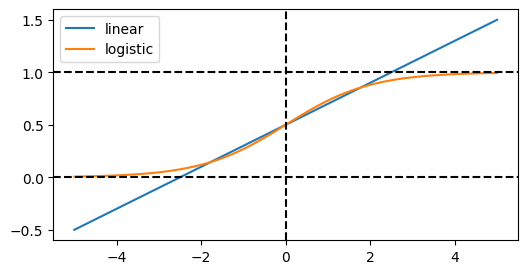

In [111]:
# logistic 함수를 출력해봅니다.

from scipy.special import expit
plt.figure(figsize=(6, 3))
x = np.linspace(-5, 5, 100)
sns.lineplot(x = x, y =  x / 5 + 0.5, label='linear')
sns.lineplot(x = x, y = expit(x), label='logistic')
plt.axvline(0, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.show()

#### 예제: MovieLens100K 데이터셋에서 추천에 활용할 수 있는 모델을 만들어 봅니다.

Task: 추천시 Ranking에 활용할 수 있도록 사용자가 영화에 평점 여부를 맞추는 모델을 만듭니다.

지표: AUC(Area Under of ROC Curve)

학습데이터:평가데이터 = 8:2

검증법: 5-fold cross validation

**로지스틱 회귀**분석을 이용한 초간단 모델을 만들어 봅니다.

입력변수: 사용자의 rating을 한 비율, 영화의 rating을 받은 비율

In [116]:
# 1. user id와 item id를 cross tab을 하여 사용자별 평가 내역이 있으면 1, 없으면 0인 DataFrame을 만듭니다.
# 2. 이를 stack 하여 user id별 item id에 대한 시청 유무를 나타내는 데이터프레임으로 변환합니다.
df_ratings_yn = df_ratings.pivot(index='user id', columns='item id', values='rating')\
        .notna().stack().rename('yn').reset_index()
df_ratings_yn.head()

,user id,item id,yn
0,1,1,True
1,1,2,True
2,1,3,True
3,1,4,True
4,1,5,True


In [117]:
df_ratings_yn.shape, df_ratings_yn['yn'].value_counts()

((1586126, 3),
 yn
 False    1486126
 True      100000
 Name: count, dtype: int64)

In [118]:
# 학습셋 8, 평가셋 2의 비율로 나눕니다.
df_train_yn, df_test_yn = train_test_split(df_ratings_yn, train_size=0.8, random_state=123)

**검증 루틴을 만들어 봅니다.**

In [124]:
# 모델 검증 프로 루틴입니다.
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score

# 5겹 교차 검증을 세팅합니다.
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
def eval_model_yn(model, df, X):
    # roc_auc_score를 지표로하는 평가 루틴을 만듭니다. 
    result = cross_validate(
        model, df[X], df['yn'], cv = cv, scoring = 'roc_auc', return_train_score = True
    )
    return result

**모델 인스턴스를 만듭니다.**

sklearn.linear_model.LogisticRegression을 활용해 봅니다.

In [125]:
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

reg_lr = make_pipeline(
    TargetEncoder(target_type = 'binary'), # Target Encoder 시청율(yn인 비율)로 user id, item id를 인코딩합니다.
    LogisticRegression() # 로지스틱 회귀모델
)
X_lr = ['user id', 'item id']

In [127]:
# 모델을 평가해봅니다.
result = eval_model_yn(reg_lr, df_train_yn, X_lr)
result, np.mean(result['test_score'])

({'fit_time': array([1.54669523, 1.3929143 , 1.36509037, 1.40807056, 1.53785443]),
  'score_time': array([0.07428885, 0.09393334, 0.09223914, 0.0877552 , 0.09917998]),
  'test_score': array([0.87879262, 0.8798312 , 0.87745542, 0.87859157, 0.87834267]),
  'train_score': array([0.88192256, 0.88138823, 0.88221667, 0.8819141 , 0.88199777])},
 np.float64(0.8786026956662665))

In [131]:
from sklearn.metrics import roc_auc_score
# reg_lr을 df_train_yn 'yn'을 예측하도록 학습시킵니다.
reg_lr.fit(df_train_yn[X_lr], df_train_yn['yn'])
# df_test_yn의 'yn'이 Positive일 확률을 예측하여 AUC를 측정합니다.
roc_auc_score(
    df_test_yn['yn'], reg_lr.predict_proba(df_test_yn[X_lr])[:, 1]
)

np.float64(0.8789710721830238)

**실습**

사용자의 직업, 성별과 영화 장르 정보를 입력 변수에 추가하여 yn  예측 모델의 기능을 추가해봅니다.

In [135]:
# gender, occupation을 활용하기 위에 df_user와 결합합니다.
# genre를 활용하기 위해 df_movie와 결합합니다.
df_train_yn_2 = df_train_yn.join(df_user, on='user id').join(df_movie, on='item id')
df_test_yn_2 = df_test_yn.join(df_user, on='user id').join(df_movie, on='item id')

In [139]:
X_genre = df_movie.columns[2:].tolist()
ct = ColumnTransformer([
    ('tge', TargetEncoder(target_type='binary'), ['user id', 'item id']),
    ('ohe', OneHotEncoder(drop='first'), ['occupation', 'gender']), # 직업과 성별의 가변수를 첫번째 범주를 제외시켜 추가합니다.
    ('pt', 'passthrough', X_genre) # 장르 정보는 직접 사용가능하므로 통과 시킵니다.
])

# ct와 Logistic Regression 결합한 모델 reg_lr_2를 만듭니다.
reg_lr_2 = make_pipeline(
    ct, LogisticRegression(C=10)
)
X_lr_2 = ['user id', 'item id', 'occupation', 'gender'] + X_genre
result = eval_model_yn(reg_lr_2, df_train_yn_2, X_lr_2)
result, np.mean(result['test_score']) # 0.8786

({'fit_time': array([4.33102131, 4.40468431, 4.33396745, 5.04420638, 4.77252316]),
  'score_time': array([0.21450615, 0.21183252, 0.22366238, 0.23194551, 0.23949885]),
  'test_score': array([0.87731872, 0.87837803, 0.87448977, 0.87629447, 0.87648896]),
  'train_score': array([0.87994629, 0.87926986, 0.88011652, 0.8798788 , 0.8798468 ])},
 np.float64(0.8765939916706167))

In [140]:
# df_train_yn_2로 reg_lr_2을 yn을 예측하도록 학습 시킵니다.
reg_lr_2.fit(df_train_yn_2[X_lr_2], df_train_yn_2['yn'])
# df_test_yn_2를 reg_lr_2로 yn이 True일 확률을 맞추도록 학습시킵니다.
roc_auc_score(
    df_test_yn_2['yn'], reg_lr_2.predict_proba(df_test_yn_2[X_lr_2])[:, 1]
)

np.float64(0.876446210047821)

### 인공신경망(Artificial Neural Network)

- 신경세포를 본 딴 모수적 모델

> 선형 회귀 모델이 나타내지 못하는 패턴(Non-Linear 패턴)을 나타낼 수 있습니다.

> 층(Layer): 입력을 처리하여 변환하는 연속된 연산 단위 

> 은닉층 (Hidden Layer): 기본적으로 가중치와 활성화 구성

  유닛(Unit) - 은닉층의 노드수: 은닉층의 출력 변수의 수
 
  가중치(Weight) - 모수(Parameter)에 해당
  
  > 밀도레이어(Dense Layer):  $N_{input} × N_{output}$ 인 행렬 \[+ $ N_{output}$ 인 벡터\]
  
 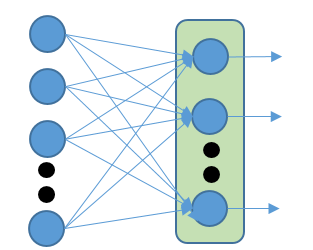
  
  활성화 함수(Activation Function)
  
  > 신경세포의 역치를 나타냄 - 신경세포에 전달된 자극이 다음 신경세포로 전달 되려면 일정 수준이상의 자극이 필요
  
  > 수학적으로는 비선형성을 부여
  
  > Ex) sigmoid / tanh / relu / leaky relu / ... 
  
  
- 학습 알고리즘: 경사하강법

[Tensorflow Playground](https://playground.tensorflow.org/)

#### 예제: MovieLens100K 데이터셋에서 추천에 활용할 수 있는 모델을 만들어 봅니다.

Task: 추천시 Ranking에 활용할 수 있도록 사용자별 영화 평점을 예측기를 만들어 봅시다. 

지표: R2

학습데이터:평가데이터 = 8:2

검증법: 5-fold cross validation

**인공신경망**모델을 이용한 초간단 모델을 만들어 봅니다.

첫번째 은닉층의 크기는 16, 두번째 은닉층의 크기는 8로 설정합니다.

입력변수: 사용자의 rating 평균, 영화의 rating 평균, 사용자의 직업, 성별과 영화 장르 정보를 입력 변수

**다층신경망 모델**

sklearn.neural_network.MLPRegressor

In [141]:
from sklearn.neural_network import MLPRegressor
X_genre = df_movie.columns[2:].tolist()
ct = ColumnTransformer([
    ('tge', TargetEncoder(target_type='continuous'), ['user id', 'item id']),
    ('ohe', OneHotEncoder(drop='first'), ['occupation', 'gender']),
    ('pt', 'passthrough', X_genre)
])

reg_mlp = make_pipeline(
    ct, 
    MLPRegressor(
        hidden_layer_sizes=[16, 8], activation='relu', 
        learning_rate_init=0.001, alpha=0.001, random_state=123
    )
)
X_mlp = ['user id', 'item id', 'occupation', 'gender'] + X_genre
result = eval_model(reg_mlp, df_train_2, X_mlp)
result, np.mean(['test_score'])

{'fit_time': array([ 7.58440638, 10.1371944 ,  6.21986151,  7.32286716,  7.04347086]),
 'score_time': array([0.01477599, 0.01315808, 0.0132637 , 0.01339436, 0.01264381]),
 'test_score': array([0.27650659, 0.29543793, 0.26707922, 0.27733375, 0.27130057]),
 'train_score': array([0.33280795, 0.32717723, 0.32433283, 0.32341015, 0.33443822])}

#### Embedding

문장, 이미지, 음성, 고차원의 범주 등 복잡도가 높은 형태의 데이터를 **저**차원의 연속형 변수로 나타낸 데이터

Ex) 영화 요약 OpenAI의 임베딩

**추천에서의 임베딩**

사용자, 아이템과 같이 고처원 범주를 인코딩하기 위해 사용합니다.


여기서, user id와 item id를 대상 변수의 비율/평균으로 인코딩하는 것이 아닌, 임베딩으로 인코딩을 해봅니다. 

이를 위해 Tensorflow를 사용해보겠습니다.

**Tensorflow**로 모델을 구성해 나가는 것을 해봅니다.


위에서 생성한 **df_train_2**, **df_test_2** 데이터셋으로 진행합니다.

**Neural Networks Architecture**

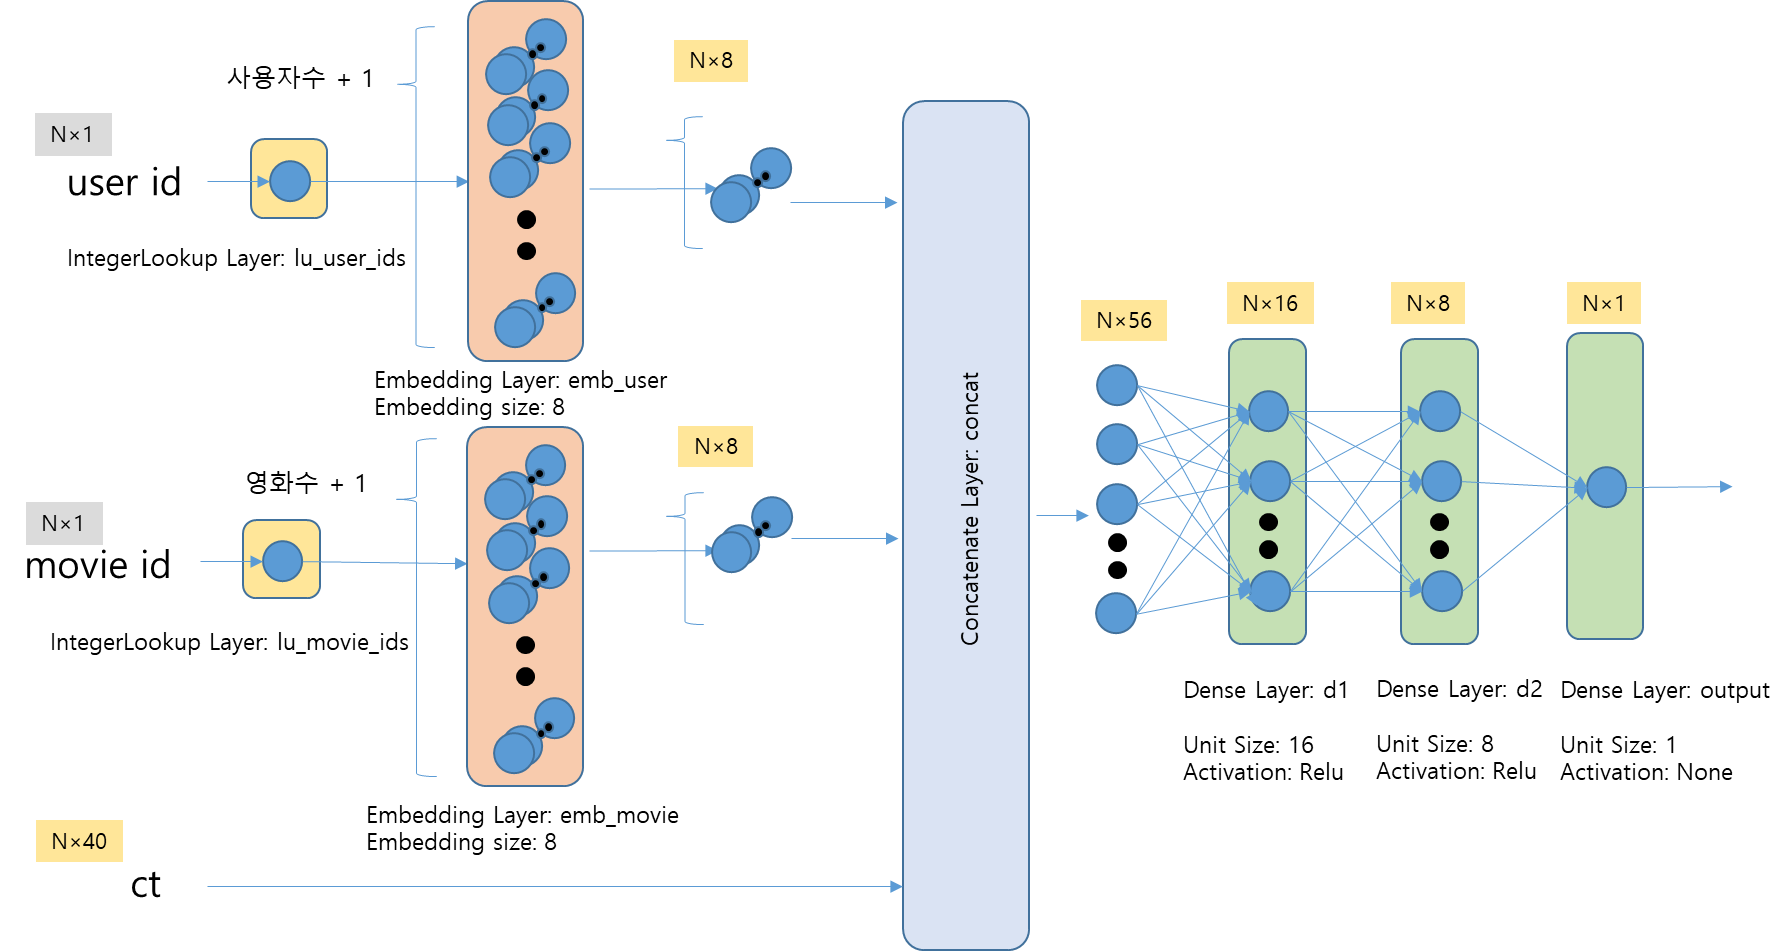

**N**: 배치 사이즈(batch size)

**ct**: 사용자 직업, 성별 가변수와 영화의 장르 여부 데이터

In [142]:
df_train_2.head()

,user id,item id,rating,date,age,gender,occupation,zip code,movie title,release date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
22302,429,24,3,1997-12-17 19:18:29,27,M,student,29205,Rumble in the Bronx (1995),23-Feb-1996,...,0,0,0,0,0,0,0,0,0,0
49609,480,511,4,1998-03-29 21:56:39,57,M,retired,98257,Lawrence of Arabia (1962),01-Jan-1962,...,0,0,0,0,0,0,0,0,1,0
89251,916,746,3,1997-11-29 22:57:42,27,M,engineer,N2L5N,Real Genius (1985),01-Jan-1985,...,0,0,0,0,0,0,0,0,0,0
96385,892,196,4,1998-02-04 16:27:02,36,M,other,45243,Dead Poets Society (1989),01-Jan-1989,...,0,0,0,0,0,0,0,0,0,0
17569,90,83,5,1998-03-31 22:34:47,60,M,educator,78155,Much Ado About Nothing (1993),01-Jan-1993,...,0,0,0,0,0,1,0,0,0,0


user id와 item id는 모두 정수형 인덱스 입니다.

Embedding Layer와 IntegerLookup Layer를 이용하여 user id와 item id를 임베딩으로 나타내는 네트워크를 디자인해 보겠습니다.

**Embedding Layer**

(범주의 개수) × (임베딩 벡터 크기)의 **학습이 가능한 Tensor**를 지니고 있으며

0-기반 위치 인덱스를 사용합니다.

tf.keras.layers.Embedding

In [146]:
# 범주의 수가 4개 이고, 벡터 크기가 2인 임베딩 레이어를 만들어 봅니다.
emb_test = tf.keras.layers.Embedding(4, 2)
# 0, 1, 2, 3 범주의 임베딩을 가져옵니다.
emb_test(tf.constant([0, 1, 2, 1])) # tf.constant 상수 Tensor를 만듭니다.

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.00857866,  0.01640913],
       [-0.02827607, -0.02460089],
       [ 0.00855494,  0.0483557 ],
       [-0.02827607, -0.02460089]], dtype=float32)>

In [145]:
emb_test.get_weights()

[array([[ 0.01307616, -0.01764773],
        [ 0.01745306,  0.0239874 ],
        [-0.02654395,  0.00823202],
        [-0.04728228,  0.00271026]], dtype=float32)]

**IntegerLookup Layer**

범주형 변수의 수준이 정수형 ID로 되어있을 때, 정수형 ID를 0-기반 위치 인덱스 변환 할 때 사용합니다.

범주형 변수이 포함한 수준들을 vocabulary라고 합니다.

vocabulary에 없는 수준이 입력되면 기본적으로 0을 반환합니다.

tf.keras.layers.IntegerLookup 

In [147]:
# IntegerLookup의 기능을 확인합니다.
# vocabulary가 [100, 200, 300] 일때,
# 입력값이 [100, 300, 1, 200] 의 출력을 확인해 봅니다.

lookup_test = tf.keras.layers.IntegerLookup(vocabulary = [100, 200, 300])
lookup_test(
    tf.constant([100, 300, 1, 200])
)

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 3, 0, 2])>

**IntegerLookup Layer + Embedding Layer**

사전에 없는 범주(Out-of Vocabulary) 까지 포함하여 임베딩 사이즈를 (범주수 + 1) x (임베딩 사이즈)로 설정합니다.

In [151]:
# vocabulary가 [100, 200, 300]인 정수이고,
# 범주의 숫자가 3이고 임베딩 벡터의 수가 2개 인 임베딩 층을 만듭니다.

lookup_test = tf.keras.layers.IntegerLookup(
    vocabulary=[100, 200, 300]
)

emb_test = tf.keras.layers.Embedding(4, 2)

# 1차원 입력 변수[100, 300, 1, 300]의 임베딩 벡터를 출력해봅니다.
x = tf.constant([100, 300, 1, 300])
print(x)
x = lookup_test(x) 
print(x)
x = emb_test(x)
print(x)
emb_test.get_weights()

tf.Tensor([100 300   1 300], shape=(4,), dtype=int32)
tf.Tensor([1 3 0 3], shape=(4,), dtype=int64)
tf.Tensor(
[[ 0.04223287  0.0451034 ]
 [ 0.02248608 -0.00827608]
 [-0.01835781  0.03320147]
 [ 0.02248608 -0.00827608]], shape=(4, 2), dtype=float32)


[array([[-0.01835781,  0.03320147],
        [ 0.04223287,  0.0451034 ],
        [-0.03773557,  0.00378504],
        [ 0.02248608, -0.00827608]], dtype=float32)]

**네트워크 일부분만 가져오겠습니다. 아래 네트워크만 우선 구현해 봅니다.**

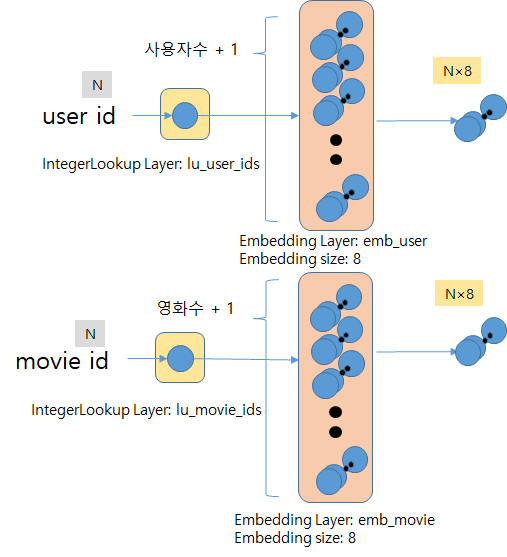

943

In [156]:
df_train_2.head()['user id']

22302    429
49609    480
89251    916
96385    892
17569     90
Name: user id, dtype: int64

In [157]:
# user id를 vocabulary로 하여 user id를 위치 index로 바꾸는 IntegerLookup Layer를 만듭니다.
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train_2['user id'].unique())
)

# user id 에 대한 Embedding Layer를 만듭니다. OOV 사이즈 1을 고려합니다.
emb_user = tf.keras.layers.Embedding(
    df_train_2['user id'].nunique() + 1, 8
)

# df_train_2에서 처음 5행의 user id 를 Tensorflow Tensor로 만듭니다.
x = tf.constant(df_train_2.head()['user id'])
# user id → 위치 Index
x = lu_userid(x)
print(x)
# 위치 Index → 임베딩
x = emb_user(x)
print(x)
x.shape

tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int64)
tf.Tensor(
[[-0.02871374 -0.00533459 -0.02115413 -0.0237986  -0.02312952 -0.00026926
   0.03543537 -0.01317225]
 [-0.03242242 -0.00058129 -0.04745215 -0.03880707  0.0499096  -0.00769569
   0.0307387   0.00633111]
 [ 0.01765535 -0.0030395  -0.01855566  0.03553517 -0.02875377 -0.01510525
  -0.03841122 -0.02806546]
 [ 0.02302277 -0.0017461   0.01282828  0.0389966   0.00516925 -0.03887277
  -0.04284451 -0.01521826]
 [-0.03196889  0.00402154 -0.03091259 -0.03553382 -0.02795747 -0.03608619
  -0.04278909  0.01263131]], shape=(5, 8), dtype=float32)


TensorShape([5, 8])

In [160]:
# item id를 vocabulary로 하여 item id를 위치 index로 바꾸는 IntegerLookup Layer를 만듭니다.
lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train_2['item id'].unique())
)

# item id에 대한 Embedding Layer를 만듭니다. OOV 사이즈 1을 고려합니다.
emb_movie = tf.keras.layers.Embedding(
    df_train_2['item id'].nunique() + 1, 8
)

# df_train_2에서 처음 5행의 item id 를 Tensorflow Tensor로 만듭니다.
x = tf.constant(df_train_2.head()['item id'])
# movie id → 위치 Index
x = lu_movieid(x)
# 위치 Index → 임베딩
x = emb_movie(x)
x

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[-0.0011468 , -0.00849358,  0.04930819,  0.02352271, -0.03899688,
        -0.01392673,  0.03361178,  0.01714084],
       [-0.04280269,  0.01731787, -0.00906305, -0.01924111, -0.0403497 ,
        -0.02571064,  0.03846964,  0.04030148],
       [-0.0053175 , -0.03652629, -0.02875552,  0.01367352, -0.00985074,
        -0.04175937, -0.04917831,  0.00986493],
       [ 0.02741701,  0.02341061,  0.0107426 ,  0.00617589,  0.04982383,
         0.01552037, -0.00379071, -0.04106996],
       [-0.02254339, -0.02145507,  0.03225198, -0.00668425, -0.03592692,
         0.01028991,  0.02994155, -0.02472606]], dtype=float32)>

**Concatenate layer**

입력 받는 tensor 들을 결합하여 하나의 tensor로 만듭니다.

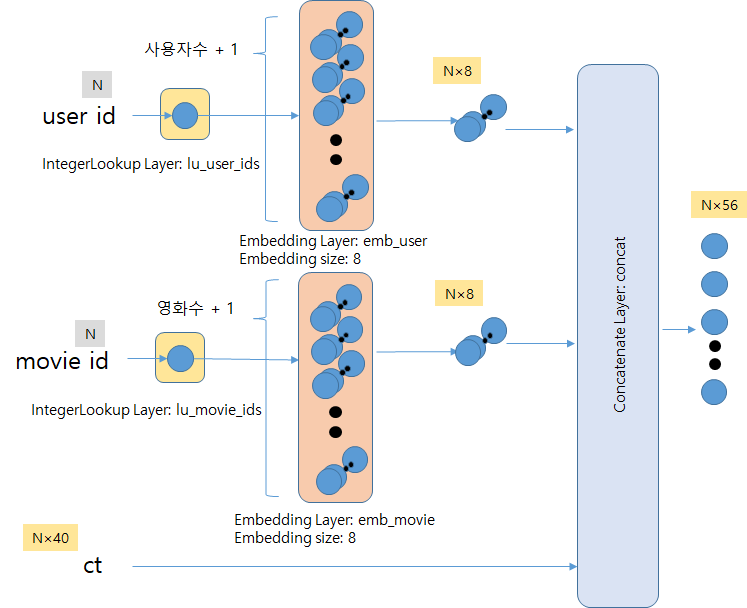

In [161]:
# ct 값을 만들기한 ColumnTransformer를 만듭니다.
# Genre와 직업, 성별을 변환기를 설정합니다.
ct = ColumnTransformer([
    ('pt', 'passthrough', X_genre),
    ('ohe', OneHotEncoder(drop='first'), ['occupation', 'gender']),
])

ct_cols = X_genre + ['occupation', 'gender']
# 학습시킵니다.
ct.fit(df_train_2[ct_cols])
print("ct values size: {}".format(len(ct.get_feature_names_out())))

ct values size: 40


In [162]:
# 처음 5줄에 대한 ct 변환값을 가져옵니다.
x_ct = ct.transform(df_train_2.head()[ct_cols])
x_ct, x_ct.shape

(array([[0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1.]]),
 (5, 40))

**Concatenate Layer**

tf.keras.layer.Concatenate(axis=결합의 기준이 되는 축(차원))

In [163]:
# 테스트를 위해 처음 부분의 user id를 가져옵니다.
x_user = tf.constant(df_train_2.head()['user id'])
x_user = lu_userid(x_user)
x_user = emb_user(x_user)
print(x_user)

# 테스트를 위해 처음 부분의 item id를 가져옵니다.
x_movie = tf.constant(df_train_2.head()['item id'])
x_movie = lu_movieid(x_movie)
x_movie = emb_movie(x_movie)
print(x_movie)

# ColumnTransformer의 출력을 가져옵니다.
x_ct = tf.constant(
    ct.transform(df_train_2.head()[ct_cols])
)

x_user.shape, x_movie.shape, x_ct.shape

tf.Tensor(
[[-0.02871374 -0.00533459 -0.02115413 -0.0237986  -0.02312952 -0.00026926
   0.03543537 -0.01317225]
 [-0.03242242 -0.00058129 -0.04745215 -0.03880707  0.0499096  -0.00769569
   0.0307387   0.00633111]
 [ 0.01765535 -0.0030395  -0.01855566  0.03553517 -0.02875377 -0.01510525
  -0.03841122 -0.02806546]
 [ 0.02302277 -0.0017461   0.01282828  0.0389966   0.00516925 -0.03887277
  -0.04284451 -0.01521826]
 [-0.03196889  0.00402154 -0.03091259 -0.03553382 -0.02795747 -0.03608619
  -0.04278909  0.01263131]], shape=(5, 8), dtype=float32)
tf.Tensor(
[[-0.0011468  -0.00849358  0.04930819  0.02352271 -0.03899688 -0.01392673
   0.03361178  0.01714084]
 [-0.04280269  0.01731787 -0.00906305 -0.01924111 -0.0403497  -0.02571064
   0.03846964  0.04030148]
 [-0.0053175  -0.03652629 -0.02875552  0.01367352 -0.00985074 -0.04175937
  -0.04917831  0.00986493]
 [ 0.02741701  0.02341061  0.0107426   0.00617589  0.04982383  0.01552037
  -0.00379071 -0.04106996]
 [-0.02254339 -0.02145507  0.03225198 

(TensorShape([5, 8]), TensorShape([5, 8]), TensorShape([5, 40]))

In [165]:
# axis = -1 마지막 차원끼리 결합을 시키는 layer를 만듭니다.
concat = tf.keras.layers.Concatenate(axis = -1)

In [167]:
# 3개의 입력값 x_user, x_movie, x_ct를 결합시킵니다.
print(x_user.shape, x_movie.shape, x_ct.shape)
x_concat = concat([x_user, x_movie, x_ct])
x_concat.shape

(5, 8) (5, 8) (5, 40)


TensorShape([5, 56])

**밀도레이어로 은닉층을 구성합니다.**


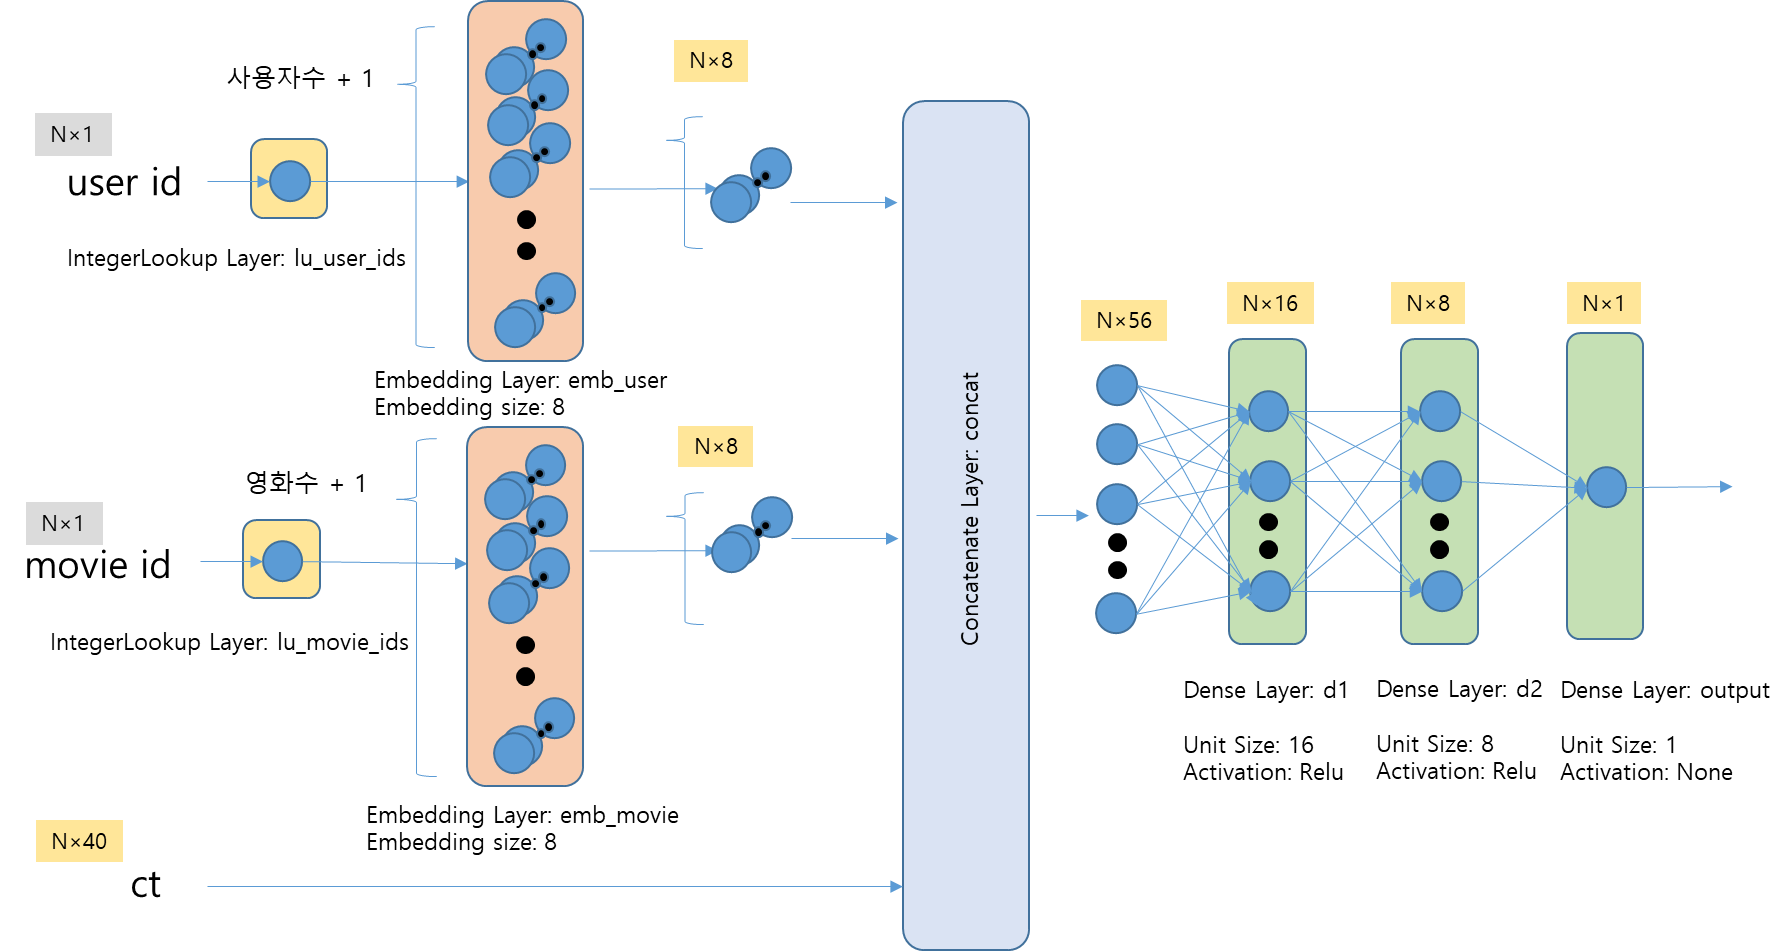

**밀도레이어**

입력과 출력이 weight와 곱으로 연결된 레이어

$O = W_{{n\_out}×{n\_in}} @ I + [Intercept_{n\_out}]$, 

@: 행렬곱, n_in: 입력 수, n_out: 출력 수

**tf.keras.layers.Dense(출력 수, activation=활성화 함수, kernel_initializer=weight 초기화 방법)**

activation: 'relu', 'sigmoid', 'tanh', ...

kernel_initialzier: 

보통은 glorot_uniform 

sigmoid, tanh와 같이 대칭 형태의 활성화 함수 - glorot_normal

relu와 같이 비대칭 - he_uniform

In [168]:
# 첫번째 밀도 레이어를 생성합니다. relu에 효과가 좋은 초기화인 he_uniform을 설정합니다.
dense1 = tf.keras.layers.Dense(16, activation = 'relu', kernel_initializer = 'he_uniform')

In [169]:
# 두번째 밀도 레이어를 생성합니다. relu에 효과가 좋은 초기화인 he_uniform을 설정합니다.
dense2 = tf.keras.layers.Dense(8, activation = 'relu', kernel_initializer = 'he_uniform')

In [175]:
# glorot_uniform 방식으로 초기화 합니다.
o = tf.keras.layers.Dense(1, activation = None, kernel_initializer = 'glorot_uniform')

In [176]:
x_h = dense1(x_concat)
print(x_h.shape)
x_h = dense2(x_h)
print(x_h.shape)
y_hat = o(x_h)
y_hat

(5, 16)
(5, 8)


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.6837708 ],
       [-0.466056  ],
       [-0.4563388 ],
       [-0.81356287],
       [-0.7501574 ]], dtype=float32)>

In [177]:
losses = tf.keras.losses.MeanSquaredError()
losses(df_train_2.head()['rating'], y_hat)

<tf.Tensor: shape=(), dtype=float32, numpy=20.339359283447266>

**Tensorflow model**

입력과 출력, 레이어 그리고 모델들로 구성된 Tensorflow 객체

모델 작성 방법(기본) 

모델의 클래스는 tf.keras.Model을 상속받습니다.

신경망이 고도화 될 수록 구조가 복잡해집니다. 복잡한 구조를 구현하기 위해서는 모듈화가 필수적입니다. 

마찬가지로 추천 시스템의 여러가지 요소들을 붙여 보다 정교한 모델을 만들어가기 위해서는 모듈화가 필요합니다. 

Tensorflow Model을 기반으로 구성 요소를 객체화하여 구현합니다.

생성자 작성: 여러가지 초기화 작업을 합니다.

    부모클래스의 생성자를 호출합니다.
    
    모델을 위한 초기화 루틴을 작성합니다.
    
    모델 레이어들의 instanace를 생성합니다.

call 메소드 작성: 모델 layer의 호출 플로우를 구현합니다. 

    입력 Tensor를 매개 변수로 정의합니다.
    
    training=False를 기본 매개 변수로 둡니다.
    
    정의한 레이어의 호출 플로우를 작성합니다.
    
    출력 텐서를 반환합니다.

In [178]:
ds = tf.data.Dataset.from_tensor_slices(
    (
        {'user_id': df_train_2['user id'], 'movie_id': df_train_2['item id'], 'ct': ct.transform(df_train_2[ct_cols])},
        df_train_2['rating']
    )
)

In [180]:
for X, y in ds.batch(32).take(1):
    print(X)
    print(y)

{'user_id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>, 'movie_id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'ct': <tf.Tensor: shape=(32, 40), dtype=float64, numpy=
array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])>}
tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


In [181]:
class RatingModel(tf.keras.Model):
    def __init__(self, user_ids, movie_ids):
        """
        RatingModel 생성자입니다.
        Parameters:
            user_ids: array-like
                등장한 user_id 수준 리스트
            movie_ids: array-like
                등장한 movie_id 수준 리스트
        """
        super().__init__() # 부모 클래스의 생성자를 호출합니다.
        
        # user id들을 사전으로 구성하여 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다.
        self.lu_user_ids = tf.keras.layers.IntegerLookup(
            vocabulary = user_ids
        )
        # movie id들을 사전으로 구성하여 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다.
        self.lu_movie_ids = tf.keras.layers.IntegerLookup(
            vocabulary = movie_ids
        )
        
        # 사용자 임베딩을 생성합니다. OOV를 포함하여 사용자수 + 1입니다.
        self.emb_user = tf.keras.layers.Embedding(
            len(user_ids) + 1, 8
        )
        # 영화 임베딩을 생성합니다. OOV를 포함하여 영화수 + 1입니다.
        self.emb_movie = tf.keras.layers.Embedding(
            len(movie_ids) + 1, 8
        )
        
        # Concatenate Layer 생성합니다.
        self.concat = tf.keras.layers.Concatenate(axis = -1)
        
        # Dense Layer 1 생성합니다. unit: 16, activation: relu,  initializer: he_uniform
        self.d1 = tf.keras.layers.Dense(16, activation = 'relu', kernel_initializer = 'he_uniform')
        # Dense Layer 2 생성합니다. unit: 8, activation: relu, initializer: he_uniform
        self.d2 = tf.keras.layers.Dense(8, activation = 'relu', kernel_initializer = 'he_uniform')
        # 출력 Layer를 생성합니다. initializer: glorot_uniform
        self.o = tf.keras.layers.Dense(1, activation = None, kernel_initializer = 'glorot_uniform')
    
    def call(self, x, training=False):
        """
        모델을 호출합니다.
        Parameters: 
            x: dict-like
                'user_id': shape이 N인 user_id 텐서
                'movie_id': shape이 N인 movie_id 텐서
                'ct': shape이 N×40인 ct 전처리기를 거친 변환된 텐서
        """
        x_user = self.lu_user_ids(x['user_id']) # 사용자 ID에서 임베딩 인덱스로 변환합니다. x['user_id'] N 정수 / x_user: N 정수
        x_user = self.emb_user(x_user) # x_user에 해당하는 임베딩을 반환합니다. x_user: N×8 정수
        x_movie = self.lu_movie_ids(x['movie_id']) # 영화 ID에서 임베딩 인덱스로 변환합니다. x['movie_id'] N 정수 / x_movie: N 정수
        x_movie = self.emb_movie(x_movie) # x_movie에 해당하는 임베딩을 반환합니다. x_movie: N×8 정수
        x = self.concat([x_user, x_movie, x['ct']])# x_user, x_movie, X['ct']을 결합합니다. X['ct']: N×40, x: N×56
        x = self.d1(x) # Dense Layer 1 x: N×16
        x = self.d2(x) # Dense Layer 2 x: N×8
        return self.o(x) # Output Layer x: N×1

In [188]:
# 5-fold cross validation을 합니다.

valid_scores_ =  []
cv = KFold(5, random_state = 1, shuffle = True)
for train_idx, test_idx in cv.split(df_train_2):
    print('Fold #{}'.format(len(valid_scores_) + 1))
    tf.keras.backend.clear_session() # Tensorflow 세션을 초기화 합니다.
    reg_nn_rating = RatingModel(
        df_train_2['user id'].unique(), 
        df_train_2['item id'].value_counts().pipe(lambda x: x.loc[x >= 5].index.tolist()) # 평점이 5회 이상인 item 만 Embedding을 사용토록 합니다.
    ) 

    # 검증 학습셋 Dataset을 만듭니다. df_train_2로  user_id: user id, movie_id: item id ct:는 ct transform으로 하고 target은 rating인 Tensorflow DataSet을 만듭니다.
    # Shuffle 10000 → Batch 128 로 처리합니다.
    ds_train_2 = df_train_2.iloc[train_idx].pipe(
        lambda x: tf.data.Dataset.from_tensor_slices(
                (
                    {'user_id': x['user id'], 'movie_id': x['item id'], 'ct': ct.transform(x[ct_cols])},
                    x['rating']
                )
            )
    ).shuffle(10000).batch(128)

    # 검증 학습셋 Dataset을 만듭니다. df_test_2로  user_id: user id, movie_id: item id ct:는 ct transform으로 하고 target은 rating인 Tensorflow DataSet을 만듭니다.
    # Batch 128 로 처리합니다.
    ds_valid_2 = df_train_2.iloc[test_idx].pipe(
        lambda x: tf.data.Dataset.from_tensor_slices(
                (
                    {'user_id': x['user id'], 'movie_id': x['item id'], 'ct': ct.transform(x[ct_cols])},
                    x['rating']
                )
            )
    ).batch(128) # 검증 테스트셋 Dataset을 만듭니다.
    
    # 모델 학습 설정을 합니다.
    reg_nn_rating.compile(
        optimizer= tf.keras.optimizers.Adam(), # Adam Optimizer를 사용합니다.
        loss= tf.keras.losses.MeanSquaredError()# 평균오차제곱합(Mean Squared Error)를 손실로 사용합니다.
    )
    # ds_train_2로 학습하고, ds_valid_2를 검증셋으로 설정합니다. 총 10회 train 셋에 대한 학습을 반복합니다.
    reg_nn_rating.fit(ds_train_2, validation_data = ds_valid_2, epochs = 10)
    # 검정 테스트셋 ds_valid_2의 의 r2_score를 측정합니다.
    valid_scores_.append(
        r2_score(
            df_train_2.iloc[test_idx]['rating'], reg_nn_rating.predict(ds_valid_2)
        )
    )
del ds_train_2, ds_valid_2
valid_scores_

Fold #1
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 4.7829 - val_loss: 0.9258
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8983 - val_loss: 0.9100
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8780 - val_loss: 0.8988
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8691 - val_loss: 0.8996
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8669 - val_loss: 0.8978
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8649 - val_loss: 0.8984
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8641 - val_loss: 0.8960
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8488 - val_loss: 0.8954
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8481 - val_loss: 0.8964
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.8502 - val_loss: 0.9005
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold #2
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 4.7174 - va

[0.28708237409591675,
 0.2784343957901001,
 0.3061313033103943,
 0.2922624945640564,
 0.2970044016838074]

In [190]:
np.mean(valid_scores_) # LR: 0.275..

np.float64(0.292182993888855)

In [191]:
# 전체 Train에 학습하고 Test로 평가합니다.
tf.keras.backend.clear_session()
reg_nn_rating = RatingModel(
    df_train_2['user id'].unique(), 
    df_train_2['item id'].value_counts().pipe(lambda x: x.loc[x >= 5].index.tolist())
)
reg_nn_rating.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.MeanSquaredError(),
)

ds_train_2 = tf.data.Dataset.from_tensor_slices(
            ({'user_id': df_train_2['user id'], 'movie_id': df_train_2['item id'], 'ct': ct.transform(df_train_2)},
              df_train_2['rating'])
        ).shuffle(10000).batch(128)

ds_test_2 = tf.data.Dataset.from_tensor_slices(
            ({'user_id': df_test_2['user id'], 'movie_id': df_test_2['item id'], 'ct': ct.transform(df_test_2)},
              df_test_2['rating'])
        ).batch(128)
reg_nn_rating.fit(ds_train_2, validation_data=ds_test_2, epochs=10)
r2_score(df_test_2['rating'], reg_nn_rating.predict(ds_test_2))

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 4.6976 - val_loss: 0.9328
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8960 - val_loss: 0.9185
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8742 - val_loss: 0.9150
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8718 - val_loss: 0.9127
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8617 - val_loss: 0.9116
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8615 - val_loss: 0.9106
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8587 - val_loss: 0.9083
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8520 - val_loss: 0.9067
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8423 - val_loss: 0.9040
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.8384 - val_loss: 0.8993
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.3026233911514282

In [192]:
reg_nn_rating.summary() # LR: 0.275..

Model: "rating_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ integer_lookup (IntegerLookup)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ integer_lookup_1                │ ?                      │             0 │
│ (IntegerLookup)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 8)              │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 8)              │        10,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,813 (221.93 KB)

 Trainable params: 18,937 (73.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,876 (147.96 KB)

In [193]:
# 추출한 내용을 Tensorflow Projector를 통해 확인해 봅니다.

import os
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

In [194]:
# 신경망을 통해 학습된 Movie Embedding을 시각화해봅니다.
log_dir='logs/nn_basic/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in df_movie.loc[
            df_train_2['item id'].value_counts().pipe(lambda x: x.loc[x >= 5].index.tolist()),
            'movie title'
        ]:
        f.write("{}\n".format(i))

# 임베딩 내용중 OOV에 해당하는 첫번째 벡터를 제외하고 기록합니다.
weights = tf.Variable(reg_nn_rating.emb_movie.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))


config = projector.ProjectorConfig()
embedding = config.embeddings.add()

embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

저장한 내용을 텐서보드로 시각화해봅니다.

wsl 커맨드 창에서, notebook이 있는 경로로 이동하여 

아래 커맨드를 실행시켜 tensorboard 서버를 구동시킵니다.

```bash
tensorboard --logdir logs/nn_basic/ --bind_all
```

브라우져에서, http://localhost:6006 에 접근하면 

tensorboard 사이트에 접근하여, 우측 상단에 드롭 박스에 Projector를 선택하면, 

Embedding을 3차원 공간에 투영시킨 시각화 결과를 볼 수 있습니다.

## (비모수적 모델) Non-Parametric Model

**모수적 모델**: 모집단의 지식(패턴)을 고정된 함수 구조로 나타내는 모델

**비모수적 모델**: 모집단의 지식(패턴)을 고정되지 않은 함수 구조로 나타내는 모델

비모수적 모델은 데이터를 나타내는 함수 구조에 대한 정보 없이 적용이 가능하여,

적용할 수 있는 데이터의 폭이 넓습니다.

### 결정 나무(Decision Tree)

 입력에 대한 판단 과정을 트리 구조로 나타낸 모델.
 
 결정나무는 데이터에 맞춰 트리를 성장시킵니다.
 
 ⇒ 지나치게 트리의 성장할 경우 과적합이 발생합니다.

 과적합에 대응하기 위한 트리의 성장을 제한 시키는 여러 규제 장치를 가지고 있습니다.

 ⇒ 정교한 튜닝이 필요합니다.
 
**모수적 모델에 비한 단점** 학습 데이터셋 전체를 메모리에 올려야 하므로, 커다란 데이터로 학습시키려면 많은 연산 자원이 필요합니다.

## 앙상블 모델

- 일반화 성능 향상을 위해 여러 모델을 결합한 모델 

### Boosting 

- 이전까지 결합된 모델의 손실(Loss)을 줄이는 모델을 결합해가는 앙상블 기법

### Bagging 

- 모델의 변동성을 줄이기 위해 Boostrapping을 통하여 다수의 모델을 만들어 변동성 줄이는 앙상블 기법

### LightGBM 으로 추천에 사용해 볼만한 모델을 만들어 봅시다. 


**LightGBM** : Microsoft Researcher를 중심으로 만든 Gradient Boosting Tree 모델입니다.

- 연속형 변수를 구간화하여 모델의 속도를 비약적으로 향상시킴과 동시에,

- 기본적인 설정으로도 상당한 성능을 얻을 수 있고, 튜닝을 통항 성능 향상을 기대할 수 있는 강력한 머신 러닝 모델입니다.

- Tabular 데이터(레코드는 행단위로 변수들은 열단위로 구성된 2차원 데이터)에 강력한 성능을 발휘합니다.

데이터셋을 만들어 봅니다.

- df_train셋에서 like 변수를 rating이 사용자의 rating 평균 이상이면 True 아니면 False로 정의하여 df_train_3 셋을 만듭니다.

- 사용자의 장르별 선호도를 구하기 위해 df_train_3에 df_movie와 결합합니다.

- 사용자가 장르별로 like를 보인 비율을 측정하고 이를 예측에 활용합니다.

- 사용자의 직업, 성별을 활용하기 위해 사용자 성별 정보도 결합합니다.

- 모수적 모델에 대한 연구가 핵심이므로,

- 검정에 시간을 투자하지 않고, 학습과 테스트만 해봅니다.

사용만 해보고 갑니다.

In [197]:
# like를 만듭니다.
df_train_3 = df_train.assign(
    like = df_train.groupby('user id')['rating'].transform('mean') < df_train['rating']
)

# test는 train에서 측정한 사용자별 평균을 기준으로 like를 구합니다.
df_test_3 = df_test.assign(
    like = lambda x: x['user id'].map(df_train.groupby('user id')['rating'].mean()) < x['rating']
).dropna()

# Genre별 선호비율 조사하기위해 genre를 결합시킵니다.
# 추가적으로 사용자 정보도 결합시킵니다.
X_genre = df_movie.columns[2:].tolist()
df_train_3 = df_train_3.join(df_movie[X_genre], on='item id').join(df_user, on='user id')
df_test_3 = df_test_3.join(df_movie[X_genre], on='item id').join(df_user, on='user id')

In [208]:
# df_train_3에서 사용자별 장르의 선호도 변수로 뽑아 봅니다.

# 영화별 여러 장르가 있으므로, 먼저 melt를 통해 user id별, genre, like 여부인 컬럼을 구성합니다.
# 피벗팅을 이용하여 사용자 장르별 like비율을 만듭니다.
# 결측치는 0으로 채웁니다.
df_user_genre = df_train_3[['user id', 'like']  + X_genre].melt(id_vars=['user id', 'like'], var_name='genre').pipe(
    lambda x: x.loc[x['value'] == 1, ['user id', 'like', 'genre']]
).pivot_table(
    index='user id', columns='genre', values='like', aggfunc='mean'
).fillna(0).rename(columns=lambda x: x + '_mean')
X_genre_mean = df_user_genre.columns.tolist()
df_user_genre.head(1)

genre,Action_mean,Adventure_mean,Animation_mean,Children's_mean,Comedy_mean,Crime_mean,Documentary_mean,Drama_mean,Fantasy_mean,Film-Noir_mean,Horror_mean,Musical_mean,Mystery_mean,Romance_mean,Sci-Fi_mean,Thriller_mean,War_mean,Western_mean,unknown_mean
user id,,,,,,,,,,,,,,,,,,,
1,0.525424,0.424242,0.333333,0.111111,0.539474,0.647059,1.0,0.724138,0.0,1.0,0.545455,0.571429,0.6,0.684211,0.763158,0.609756,0.6,0.5,0.0


In [209]:
# df_train_3와 df_test_3에  df_user_genre를 결합시킵니다.

df_train_3 = df_train_3.join(df_user_genre, on='user id', how='inner')
df_test_3 = df_test_3.join(df_user_genre, on='user id', how = 'inner')
display(df_train_3.head())
display(df_test_3.head())

,user id,item id,rating,date,like,unknown,Action,Adventure,Animation,Children's,...,Film-Noir_mean,Horror_mean,Musical_mean,Mystery_mean,Romance_mean,Sci-Fi_mean,Thriller_mean,War_mean,Western_mean,unknown_mean
22302,429,24,3,1997-12-17 19:18:29,False,0,1,1,0,0,...,0.833333,0.346154,0.214286,0.785714,0.392157,0.441176,0.448276,0.666667,0.875000,0.0
49609,480,511,4,1998-03-29 21:56:39,True,0,0,1,0,0,...,1.000000,0.600000,0.800000,1.000000,0.500000,0.600000,0.750000,0.600000,1.000000,0.0
89251,916,746,3,1997-11-29 22:57:42,False,0,0,0,0,0,...,0.500000,0.416667,0.285714,0.333333,0.469388,0.419355,0.311475,0.681818,0.166667,0.0
96385,892,196,4,1998-02-04 16:27:02,True,0,0,0,0,0,...,1.000000,0.600000,0.400000,0.857143,0.694444,0.880000,0.821429,0.842105,0.625000,0.0
17569,90,83,5,1998-03-31 22:34:47,True,0,0,0,0,0,...,1.000000,0.333333,0.818182,0.666667,0.563636,0.500000,0.538462,0.541667,1.000000,0.0


,user id,item id,rating,date,like,unknown,Action,Adventure,Animation,Children's,...,Film-Noir_mean,Horror_mean,Musical_mean,Mystery_mean,Romance_mean,Sci-Fi_mean,Thriller_mean,War_mean,Western_mean,unknown_mean
42083,600,651,4,1998-02-26 00:04:52,True,0,1,0,0,0,...,0.000000,0.500000,0.000,0.000000,0.625000,0.500000,0.600000,1.000000,0.666667,0.0
71825,607,494,5,1998-01-04 02:05:56,True,0,0,0,0,0,...,0.000000,0.000000,0.000,0.000000,0.875000,0.500000,1.000000,0.875000,0.000000,0.0
99535,875,1103,5,1997-10-10 06:32:24,True,0,0,0,0,0,...,0.333333,0.000000,0.000,0.285714,0.312500,0.363636,0.333333,0.500000,0.000000,0.0
47879,648,238,3,1997-12-15 19:18:55,False,0,0,0,0,0,...,1.000000,0.333333,0.375,0.625000,0.437500,0.609756,0.648649,0.695652,0.600000,0.0
36734,113,273,4,1997-10-04 03:26:49,True,0,1,0,0,0,...,1.000000,0.000000,0.000,0.500000,0.666667,0.600000,0.461538,0.666667,0.000000,0.0


In [213]:
import lightgbm as lgbm
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

X_genre = df_movie.columns[2:].tolist()
X_lgb = [i for i in df_train_3.columns if i not in['date', 'like', 'zip code', 'rating']]
ct = ColumnTransformer([
    ('tge', TargetEncoder(target_type='binary'), ['user id', 'item id']),
    ('ohe', OneHotEncoder(), ['gender', 'occupation']),
    ('pt', 'passthrough', [i for i in X_lgb if i not in ['gender', 'occupation', 'user id', 'item id']])
])
clf_lgb = make_pipeline(
    ct, 
    lgbm.LGBMClassifier(random_state=123, verbose=-1)
)
clf_lgb.fit(df_train_3[X_lgb], df_train_3['like'])

(
    roc_auc_score(df_train_3['like'], clf_lgb.predict_proba(df_train_3[X_lgb])[:, 1]),
    roc_auc_score(df_test_3['like'], clf_lgb.predict_proba(df_test_3[X_lgb])[:, 1]),
)

/home/rcmd/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rcmd/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


(np.float64(0.8218406752798733), np.float64(0.7437820056574946))

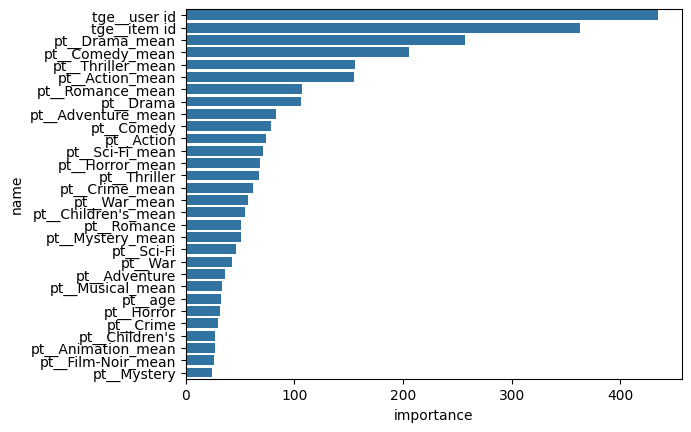

In [214]:
sns.barplot( 
    data=pd.DataFrame({
        'name': clf_lgb[0].get_feature_names_out(),
        'importance': clf_lgb[1].feature_importances_
    }).sort_values('importance', ascending=False).iloc[:30],
    x='importance', y='name'
)
plt.show()

**참고용 코드**

5겹의 교차 검증을 통한 평가 루틴입니다.

In [215]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# like를 만듭니다.
df_train_3 = df_train.assign(
    like = df_train.groupby('user id')['rating'].transform('mean') < df_train['rating']
)

# test는 train에서 측정한 사용자별 평균을 기준으로 like를 구합니다.
df_test_3 = df_test.assign(
    like = lambda x: x['user id'].map(df_train.groupby('user id')['rating'].mean()) < x['rating']
).dropna()

# Genre별 선호비율 조사하기위해 genre를 결합시킵니다.
# 추가적으로 사용자 정보도 결합시킵니다.
X_genre = df_movie.columns[2:].tolist()
df_train_3 = df_train_3.join(df_movie[X_genre], on='item id').join(df_user, on='user id')
df_test_3 = df_test_3.join(df_movie[X_genre], on='item id').join(df_user, on='user id')

# 5-fold cross validation을 합니다.

cv = KFold(n_splits=5, random_state=123, shuffle=True)
def eval_model(model, X):
    train_scores_ = []
    valid_scores_ = []
    for train_idx, test_idx in cv.split(df_train_3):
        df_cv_train = df_train_3.iloc[train_idx]
        df_cv_test = df_train_3.iloc[test_idx]
        # CV train set에서 선호도를 구합니다.
        df_user_genre = df_cv_train[['user id', 'like']  + X_genre].melt(id_vars=['user id', 'like'], var_name='genre').pipe(
            lambda x: x.loc[x['value'] == 1, ['user id', 'like', 'genre']]
        ).pivot_table(
            index='user id', columns='genre', values='like', aggfunc='mean'
        ).fillna(0).rename(columns=lambda x: x + '_mean')
        X_genre_mean = df_user_genre.columns.tolist()
                # CV train에서 구한 선호도를 결합합니다.
        df_cv_train = df_cv_train.join(df_user_genre, on='user id', how='left').fillna(0)
        # CV test에는 CV train에서 구한 통계치를 적용합니다.
        df_cv_test = df_cv_test.join(df_user_genre, on='user id', how='left').fillna(0)
        
        model.fit(df_cv_train[X], df_cv_train['like'])
        train_scores_.append(roc_auc_score(df_cv_train['like'], model.predict_proba(df_cv_train[X])[:, 1]))
        valid_scores_.append(roc_auc_score(df_cv_test['like'], model.predict_proba(df_cv_test[X])[:, 1]))
    return train_scores_, valid_scores_

In [216]:
import lightgbm as lgbm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

X_genre = df_movie.columns[2:].tolist()
X_lgb = [i for i in df_train_3.columns if i not in['date', 'like', 'zip code', 'rating']] + X_genre_mean
ct = ColumnTransformer([
    ('tge', TargetEncoder(target_type='binary'), ['user id', 'item id']),
    ('ohe', OneHotEncoder(), ['gender', 'occupation']),
    ('pt', 'passthrough', [i for i in X_lgb if i not in ['gender', 'occupation', 'user id', 'item id']])
])
clf_lgb = make_pipeline(
    ct, 
    lgbm.LGBMClassifier(random_state=123, verbose=-1)
)
eval_model(clf_lgb, X_lgb)

/home/rcmd/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rcmd/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rcmd/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rcmd/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rcmd/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


([np.float64(0.8304059800701824),
  np.float64(0.8314864836120905),
  np.float64(0.8311291940959149),
  np.float64(0.8324324980420834),
  np.float64(0.8324654552653373)],
 [np.float64(0.7274707296434624),
  np.float64(0.7294966621097886),
  np.float64(0.7239018271888171),
  np.float64(0.7217251644908032),
  np.float64(0.7294650982653064)])

# 비지도 학습

- 군집화(Clustering ): 비슷한 속성을 지닌 데이터 포인트를 그룹화하는 과정

- 차원축소(Dimension Reduction): 정보의 손실을 최소화하여 데이터의 변수의 수를 줄이는 과정

**예제: 차원 축소 기법을 활용한 초간단 텍스트 마이닝**

영화 줄거리 데이터에서, Bag-of-words 모델 + TF-IDF 변환 + TruncatedSVD 모델을 이용한 텍스트 임베딩 추출

> Bag-of-words : 문서를 단어들의 출현 빈도로 나타냅니다.

> TF-IDF 변환: 단어 빈도수를 전체 문서들에서 두루 나오는 단어의 가중치를 낮추어 변환합니다.

> TruncatedSVD: 입력 변수의 수를 줄입니다.

→ LSA(Latent Semantic Allocation) model

In [217]:
with open('dataset/tmdb_movie_info_kr.pkl', 'rb') as f:
    movie_info_kr = pkl.load(f)

In [218]:
movie_info_kr[1]['overview']

'카우보이 인형 우디는 꼬마 주인인 앤디의 가장 사랑받는 장난감이다. 그러나 어느날 버즈라는 새로운 장난감이 등장한다.  버즈는 최신형 장난감으로 레이저 빔 등의 첨단장비를 갖추고 있으나, 버즈는 자신이 장난감임을 인식하지 못하고 자신이 우주에서 온 전사이며 자신이 갖춘 장비로 하늘을 날 수 있다고 믿고 있다. 버즈의 허상을 상처받지 않고 인식시켜 주려는 우디와 친구들. 그러나 뜻밖의 사고가 일어난다. 옆집 개에게 버즈가 납치당하고 이런 버즈를 구하기 위해 우디와 친구들은 구조대를 조직해 버즈를 구하러 가는데...'

한글 형태소 분석기: 어절에서 형태소 단위의 분리를 해주며, 이와 함께  형태소의 품사를 제공합니다.

[KIWI](https://github.com/bab2min/kiwipiepy)

In [219]:
# 한글 형태소 분석기: 형태소 분석기를 통해 어절에서 단어를 추출합니다. 

from kiwipiepy import Kiwi
from tqdm import tqdm
kiwi = Kiwi()

In [220]:
kiwi.analyze(movie_info_kr[1]['overview'])

[([Token(form='카우보이', tag='NNG', start=0, len=4),
   Token(form='인형', tag='NNG', start=5, len=2),
   Token(form='우디', tag='NNP', start=8, len=2),
   Token(form='는', tag='JX', start=10, len=1),
   Token(form='꼬마', tag='NNG', start=12, len=2),
   Token(form='주인', tag='NNG', start=15, len=2),
   Token(form='이', tag='VCP', start=17, len=1),
   Token(form='ᆫ', tag='ETM', start=17, len=1),
   Token(form='앤디', tag='NNP', start=19, len=2),
   Token(form='의', tag='JKG', start=21, len=1),
   Token(form='가장', tag='MAG', start=23, len=2),
   Token(form='사랑', tag='NNG', start=26, len=2),
   Token(form='받', tag='VV-R', start=28, len=1),
   Token(form='는', tag='ETM', start=29, len=1),
   Token(form='장난감', tag='NNG', start=31, len=3),
   Token(form='이', tag='VCP', start=34, len=1),
   Token(form='다', tag='EF', start=35, len=1),
   Token(form='.', tag='SF', start=36, len=1),
   Token(form='그러나', tag='MAJ', start=38, len=3),
   Token(form='어느', tag='MM', start=42, len=2),
   Token(form='날', tag='NNG', s

단어 자체만으로 의미를 지닌다고 보기 힘든, 조사(tag가 J로 시작) 어미(tag가 E로 시작), 접미사(tag X로 시작), 문장부호(tag S로 시작) 주격보어(VCP) 하는 단어들은 불용어 처리합니다.

In [221]:
words = [t.form for t in kiwi.tokenize(movie_info_kr[1]['overview']) if t.tag[0] not in ['J', 'E', 'X', 'S'] and t.tag != 'VCP']
words

['카우보이',
 '인형',
 '우디',
 '꼬마',
 '주인',
 '앤디',
 '가장',
 '사랑',
 '받',
 '장난감',
 '그러나',
 '어느',
 '날',
 '버즈',
 '새롭',
 '장난감',
 '등장',
 '버즈',
 '최신',
 '장난감',
 '레이저',
 '빔',
 '등',
 '첨단',
 '장비',
 '갖추',
 '있',
 '버즈',
 '자신',
 '장난감',
 '인식',
 '못하',
 '자신',
 '우주',
 '오',
 '전사',
 '자신',
 '갖추',
 '장비',
 '하늘',
 '날',
 '수',
 '있',
 '믿',
 '있',
 '버즈',
 '허상',
 '상처',
 '받',
 '않',
 '인식',
 '주',
 '우디',
 '친구',
 '그러나',
 '뜻밖',
 '사고',
 '일어나',
 '옆집',
 '개',
 '버즈',
 '납치',
 '이런',
 '버즈',
 '구하',
 '위하',
 '우디',
 '친구',
 '구조대',
 '조직',
 '버즈',
 '구하',
 '가']

In [222]:
# Document(doc): 영화 한 편의 줄거리와 제목 
# 각각의 Documenst들에서 불용어를 제외한 단어를 추출합니다.
doc_ids = []
docs = []
for k, v in tqdm(movie_info_kr.items()):
    words = [t.form for t in kiwi.tokenize(v['title']) if t.tag[0] not in ['J', 'E', 'X', 'S'] and t.tag != 'VCP']
    words += [t.form for t in kiwi.tokenize(v['overview']) if t.tag[0] not in ['J', 'E', 'X', 'S'] and t.tag != 'VCP']
    doc_ids.append(k)
    docs.append(words)

100%|████████████████████████████████████████████████████████████████████████████| 61571/61571 [01:58<00:00, 520.69it/s]


In [223]:
# 처음 두 개의 Document의 내용을 뽑아봅니다.
docs_str = [' '.join(i) for i in docs]
docs_str[:2]

['토이 스토리 카우보이 인형 우디 꼬마 주인 앤디 가장 사랑 받 장난감 그러나 어느 날 버즈 새롭 장난감 등장 버즈 최신 장난감 레이저 빔 등 첨단 장비 갖추 있 버즈 자신 장난감 인식 못하 자신 우주 오 전사 자신 갖추 장비 하늘 날 수 있 믿 있 버즈 허상 상처 받 않 인식 주 우디 친구 그러나 뜻밖 사고 일어나 옆집 개 버즈 납치 이런 버즈 구하 위하 우디 친구 구조대 조직 버즈 구하 가',
 '쥬만지 년 공장 운영 아버지 밑 자라 열두 살 소년 앨런 어느 날 공장 신축 부지 이상 북소리 듣 소리 따라가 앨런 나무 만들 지 이상 게임 판 발견 마침 집 오 새라 함께 게임 하 앨런 그만 게임 마법 걸리 게임 판 속 흔적 없이 사라지 년 쥬디 피터 교통사고 부모 잃 고모 함께 살 위하 값 싸 커다랗 집 이사 오 어느 날 고모 직장 출근 나 뒤 두 아이 먼지 쌓이 다락방 들려오 이상 북소리 듣 되 북소리 이끌리 쥬디 피터 찾아내 것 쥬만지 게임 판 호기심 많 두 아이 게임 판 지시 따르 주사위 던지 지금껏 한 번 보 적 없 세계 만나 되 그 게임 그만두 하 자신 의지 상관없이 게임 계속']

In [224]:
# CountVectorizer: Bag of Words Model의 sklearn version 입니다.
from sklearn.feature_extraction.text import CountVectorizer
# Document Frequency: 최소 3개의 문서에서 등장한 단어를 Vocabulary에 포함합니다.
cnt_vec = CountVectorizer(min_df=3)
cnt_vec.fit(docs_str)

CountVectorizer(min_df=3)

In [225]:
# Vocabulary에 22594(KIWI 형태소 분석기 버젼에 따라 수치가 다를 수있습니다)개의 단어가 포함 됐습니다.
len(cnt_vec.vocabulary_)

22594

In [226]:
[docs_str[0]]

['토이 스토리 카우보이 인형 우디 꼬마 주인 앤디 가장 사랑 받 장난감 그러나 어느 날 버즈 새롭 장난감 등장 버즈 최신 장난감 레이저 빔 등 첨단 장비 갖추 있 버즈 자신 장난감 인식 못하 자신 우주 오 전사 자신 갖추 장비 하늘 날 수 있 믿 있 버즈 허상 상처 받 않 인식 주 우디 친구 그러나 뜻밖 사고 일어나 옆집 개 버즈 납치 이런 버즈 구하 위하 우디 친구 구조대 조직 버즈 구하 가']

In [227]:
# 첫번째 문장만의 변환값을 가져옵니다.
vec = cnt_vec.transform([docs_str[0]])[0]
# 단어 출현빈도를 출력해 봅니다.
for k, l in zip(vec.data, cnt_vec.get_feature_names_out()[vec.indices]):
    print(l, k)

가장 1
갖추 2
구조대 1
구하 2
그러나 2
꼬마 1
납치 1
등장 1
뜻밖 1
레이저 1
못하 1
버즈 7
사고 1
사랑 1
상처 1
새롭 1
스토리 1
앤디 1
어느 1
옆집 1
우디 3
우주 1
위하 1
이런 1
인식 2
인형 1
일어나 1
자신 3
장난감 4
장비 2
전사 1
조직 1
주인 1
첨단 1
최신 1
친구 2
카우보이 1
토이 1
하늘 1
허상 1


TFIDF 변환을 통해 두루 나오는 단어의 가중치를 낮춰줍니다.

$tf(t, d)  = \frac{f_{t,d}}{\sum_{t'∈f_{f',d}}f_{t',d}}$

$idf(t, D) = \log{\frac{N}{|\{d∈D: t∈d\}|}}$

$tfidf(t, d, D) = tf(t,d)\cdot idf(t, D)$

In [228]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_tf = TfidfTransformer()

In [229]:
tfidf_tf.fit(cnt_vec.transform(docs_str))

TfidfTransformer()

In [230]:
vec = tfidf_tf.transform(cnt_vec.transform([docs_str[0]]))[0]
for k, l in zip(vec.data, cnt_vec.get_feature_names_out()[vec.indices]):
    print(l, k)

가장 0.05354856523216947
갖추 0.15574915778062465
구조대 0.09393629240757201
구하 0.10493053899465263
그러나 0.08845520616096812
꼬마 0.07858560660113552
납치 0.060321594105084114
등장 0.06510853376146795
뜻밖 0.07822446658716514
레이저 0.09365196110216559
못하 0.04669407883259998
버즈 0.7228305556929183
사고 0.05498742753834614
사랑 0.04146353415345078
상처 0.06600561020370545
새롭 0.05205684315377883
스토리 0.07229036785762441
앤디 0.08393761889977662
어느 0.04033480524884205
옆집 0.08260173068957344
우디 0.2727706718359001
우주 0.07072806338215351
위하 0.035140761036374236
이런 0.06692849993159972
인식 0.17639894408522339
인형 0.08007474803815491
일어나 0.05862344996331338
자신 0.11009244793332866
장난감 0.3429122799048956
장비 0.17538549519014038
전사 0.07519084529508756
조직 0.05897640115216873
주인 0.06533181122870944
첨단 0.0823937527702445
최신 0.09547712777560069
친구 0.08490738959441423
카우보이 0.08659237992380113
토이 0.10466715096625928
하늘 0.07325232018727641
허상 0.11040397133121957


In [231]:
vec, len(docs_str)

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 40 stored elements and shape (1, 22594)>,
 61571)

CountVectorizer → TFIDF 를 거쳐나온 문서 Matrix의 사이즈는 |D|×|V| , |D|: 문서수 |D|=61571, |V|: 단어수, |V| = 22266

TruncatedSVD를  이용하여, 문서 Matrix의 사이즈를 축소시킵니다.

In [235]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

# LSA(Latent Semantic Allocation)
# CountVectorizer → TFIDF → TruncatedSVD
lsa = make_pipeline(
    CountVectorizer(min_df = 3), #  3개 이상의 문서가 나오는 단어를 사전에 포함시키는 Bag-of-Word 모델 변환기를 설정합니다.
    TfidfTransformer(), # TF-IDF 변환기를 설정합니다.
    TruncatedSVD(128)# Truncated SVD 모델을 사용하여, 22XXX개에서 128개로 사이즈를 축소시킵니다.
)
lsa.fit(docs_str)

Pipeline(steps=[('countvectorizer', CountVectorizer(min_df=3)),
                ('tfidftransformer', TfidfTransformer()),
                ('truncatedsvd', TruncatedSVD(n_components=128))])

In [236]:
lsa.transform(docs_str[:2]).shape

(2, 128)

In [237]:
# 전체의 변동성(정보) 중에서 512 차원의 데이터가 설명하는 변동성(정보)를 구합니다.
np.sum(lsa[2].explained_variance_ratio_)

np.float64(0.1267376040880649)

In [238]:
# 추출한 내용을 Tensorflow Projector를 통해 확인해 봅니다.

import os
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [239]:
# Tensorboard에 출력할 내용이 담긴 폴더를 설정합니다.
log_dir='logs/lsa/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding과 출력될 Metadata를 기록합니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in doc_ids:
        f.write("{}\n".format(movie_info_kr[i]['title']))

# Embedding의 내용을 설정합니다.
weights = tf.Variable(lsa.transform(docs_str))
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 설정에 따라 임베딩을 기록합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
# 이 경우에는 wsl 커맨드 창을 통해  tensorboard를 구동한 방법은 
# 서버를 종료할 때에 서버 Process를 구동 시킨 wsl 창에서
# 서버를 직접 종료하면 됩니다지만(Ctrl + C)
# 아래 방법은 Notebook 창에서 tensorboard를 직접 구동시키는 방법인데요,
# wsl 환경에서는 서버가 정상적으로 종료 되지 않고 ghost processing가 되어 버려서
# wsl 환경에서 진행하신다면 아래 명령을 수행하는 것을 권장하지 않습니다.
# 이 경우에는 wsl 커맨드 창을 통해 구동하는 것을 권장합니다.

# %tensorboard --logdir logs/lsa/ --bind_all

In [ ]:
# tensorboard 서버 process 번호를 조회합니다.
# !ps -ef|grep tensorboard

In [ ]:
# tensorboard Process를 조회 후 Process를 종료시킵니다.
# !kill [tensorboard PID]